# K-Means clustering from scratch
Author: [Ryan Parker](https://github.com/rparkr)  
In this notebook, I implement a vectorized version of the k-means clustering algorithm and use it to create color palettes from an input image. Like the other notebooks in my _ML from scratch_ series, I implemented the algorithm without referencing anyone else's code, as an exercise for me to deeply understand common ML techniques.

K-Means is an algorithm that finds groups, or _clusters_, in a dataset by:
1. choosing $k$ starting data points as the cluster centers
2. assigning all remaining data points to a cluster based on the cluster center nearest to them
3. computing the new cluster center as the mean of all the points in that cluster
4. repeating steps 2-3 until convergence, which occurs when no points are reassigned after successive iterations

**What is it useful for?**  
Clustering algorithms are _unsupervised_: there is no label, or target, to predict. Instead, the algorithm seeks to find a pattern in the data, which can help group data into simlar categories. Some example uses of clustering include:
- find related items (products, articles, observations) to an item of interest
- group text documents, like comments or reviews, into categories (topic modeling)
- segment customers
- compress images by reducing the colors used
- categorize transactions


**Demonstrations**

|           Sample data          |           Color palettes          |
|:------------------------------:|:---------------------------------:|
|<img src="../images/kmeans_training_2.gif" width="500px">|  <img src="../images/kmeans_2.png" width="500px"> |

## Next steps
1. Find the best 5 clusters out of a given number (say, 15-20) by using a formula like this: `(% of all data points with that label / % of total avg. distance for that label)`. For example, if a cluster has a ton of data points (maybe 20% of total) but also has a great deal of dispersion among the data points (like 10% of the sum of avg. distance for each cluster), the ranking wouldn't be as high as a cluster with fewer points (maybe 5% of total) but very tightly clustered (e.g., 1% of total). Using that ranking methodology, return the top-5 clusters to use for the color palette and [sort by HSV](https://matplotlib.org/stable/gallery/color/named_colors.html#helper-function-for-plotting) to put them in perceptual order.
2. ✅ Write a function that plots a color palette next to an image, along with the nearest named colors to that palette (perhaps as small rectangles under the color palette boxes)
3. ✅ Adjust `normalize` in `_preprocess()` to normalize by column, rather than by the whole dataset (e.g., for use with HSV color space, where hue ranges from 0-360 while saturation and value range from 0-1)
4. ✅ Add a function to unnormalize data (that is, put it back in original scale) -- and store the unnormalized data in `centers_` and `hist_`; then update the plotting functionality so it doesn't unnormalize.
5. ✅ Update functionality that unnormalizes data (especially cluster centers) to use the unnormalizing function
6. ✅ Add option to compute clusters in HSV color space or RGB color space
7. ✅ Compare the clustering results from HSV and RGB color spaces
8. Place functionality in a `kmeans.py` file and import it `as km` at the top of the module, with a one-line call to a function that creates a color palette from an image
9.  Consider organizing imports to label where they are used
10. ✅ Search for other TODOs noted in the comments
11. Add unit tests to `KMeans` class and its methods
12. Run `python -m doctest kmeans.py` to test the unit tests
13. Update the header images (create a new .gif and .mp4 of training progress, add picture of color palette)
14. Rearrange notebook so the `step by step` part showing the simple version of the algorithm comes before the entire class, which has a lot of additional code for robustness and utility as an API
15. ✅ In the `plot_scatter()` method, limit the number of samples rendered to 1,000-5,000 points (selected at random from the provided dataset). That will greatly speed up computation compared to rendering 20k+ data points in a single chart (unnecessary, since the scatter plot will show the same trends with fewer data points)
16. Add an option to the color palette function to hide the nearest named colors (they can make the plot busier and less cohesive)

# Setup
Import required packages and create a sample dataset.

I implement the algorithm using only `numpy`, but I use `matplotlib` for visualization, `sklearn` for creating a sample dataset, `pillow` for loading images into `numpy` arrays, and `tqdm` for creating progress bars during model fit.

In [18]:
# Built-in modules
from pathlib import Path  # create a folder for saving plots of each training iteration
import sys  # check whether the code is run in a Jupyter notebook (for the animated plot function)
import time  # pause code execution, for creating plot animations
import urllib.request  # download images using urllib.request.urlopen()

# Optional: ignore the "mean of empty slice" RuntimeWarning issued by NumPy
# when a cluster has no points assigned to it, when calculating average
# distance in the KMeans.fit() method
# import warnings
# warnings.simplefilter(action='ignore', category=RuntimeWarning)

# External packages
from IPython.display import clear_output  # create simple animations with multiple Matplotlib plots
import matplotlib.colors as mcolors  # for accessing color names and choosing color palettes
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle  # for drawing boxes on plots
import numpy as np
from PIL import Image  # the pillow package for loading images into np arrays
from sklearn.datasets import make_classification
from tqdm.auto import tqdm  # display progress bars

# K-Means algorithm
In this section, I define a class that implements the k-means clustering algorithm.

In [161]:
class KMeans():
    def __init__(
            self,
            k: int = 4,
            n_rounds: int = 10,
            max_iter: int = 100,
            threshold: float = 0.001,
            cluster_axis: int = -1,
            save_hist: bool = False,
            verbose: bool = False,
            random_state = None) -> None:
        '''Create an object to perform K-Means clustering on a dataset.

        To determine clusters, the K-Means algorithm:
        1. chooses `k` starting data points as the cluster centers
        2. classifies each data point by the cluster center nearest to it
        3. updates the cluster centers to the mean of all the points in that
           cluster
        4. repeats steps 2-3 until convergence: when cluster centers move less
           than `threshold` or when `max_iter` iterations are reached.
        
        # Parameters
        `k`: int, default=4
            The number of clusters to create.
        `n_rounds`: int, default=10
            The number of rounds for the clustering algorithm to run, each
            starting with randomly-chosen initial centers. The best-performing
            run will be returned, as determined by the set of clusters that
            minimizes the average squared distance between points and cluster
            centers.
        `max_iter`: int, default=100
            The maximum number of iterations in a single round. If convergence
            isn't reached by this number of iterations, the algorithm will move
            on to the next round.
        `threshold`: float, default=0.001
            Set the stopping criteria for model fit: if the average change
            for all cluster centers from the previous iteration to the current
            iteration is below this threshold, the algorithm is converged
            and no futher iterations will be peformed in the current round.
            Note that the dataset is normalized on a scale of 0-1 prior to
            running the algorithm, so this convergence criteria applies to data
            on that scale. The default threshold of 0.001 is a 0.1% change in
            cluster centers on each dimension.
        `cluster_axis`: int, default=-1
            The axis to use for clustering; all other axes will be treated as
            samples in the row dimension. The KMeans algorithm uses
            a two-dimensional dataset: each row is a sample, and the columns
            are the features for that sample. If the given dataset has
            more than two axes, the data will be reshaped into 2-D prior to
            fitting the KMeans algorithm. The cluster_axis parameter sets the
            axis that will be used as the columns axis for clustering; all other
            axes will be reshaped into the row dimension. For example, an image
            has 3 axes: height, width, RGB. By default, KMeans will reshape
            the height and width axes into the row dimension and will use the
            RGB values as columns, thus creating a reshaped array of shape:
            (height x width, 3) where the clusters are pixels in RGB space.
        `save_hist`: bool, default=False
            Whether to store data on the cluster centroids during each training
            iteration from model fit. Use only when you plan to use the
            `plot_animate()` method to show training progress, since the history
            increases the memory used by the KMeans object.
        `verbose`: bool, default=False
            If `True`, print outputs showing the progress of model fit.
        `random_state`: int, default=None
            If set, this value will be used as the seed when initializing
            cluster centers.
        
        # Attributes
        `best_round_`: the clustering round that had the smallest avg distance
            between points and their assigned cluster centers.
        `centers_`: the centers of the `k` clusters based on the best
            fit learned after performing `n_rounds` of the algorithm.
        `distances_`: the average distance (array norm) from each cluster
            center to the points assigned to that cluster.
        `data_min_`: the minimum value of the training data passed to .fit().
            Used for normalizing data before running the algorithm.
        `data_max_`: the maximum value of the training data passed to .fit().
            Used for normalizing data before running the algorithm.
        `hist_`: a 3-d array of the cluster centers from each training
            iteration of the best clustering round. Only available if
            `save_hist=True`. Used by the `plot_animate()` method to create
            an animation of training progress.
            Shape: (num_iter, num_clusters, num_features)
        `num_iters_`: the number of iterations before convergence in the best
            clustering round.

        # Methods
        `fit(X)`: train the model to learn the best cluster centers based on
            a dataset (`X`, a NumPy array)
        `classify(X)`: assign cluster labels to data based on the cluster
            centers learned through `fit()`
        `predict(X)`: alias for `classify(X)`
        `plot_scatter(X)`: display a Matplotlib scatter plot of the clusters.
        `plot_animate(X)`: display an animated Matplotlib scatter plot showing
            training progress and final cluster assignments. Requires
            `save_hist` to be set to `True` prior to model fit.
        '''
        # Store arguments passed on instantiation
        self.__dict__.update(locals())
    

    def _preprocess(
            self,
            data: np.ndarray,
            features_selected: list | None = None,
            normalize: bool = True,
            set_min_max: bool = False) -> np.ndarray:
        '''Normalize data and ensure it is in the proper 2-D format.'''
        # Copy the data first to ensure the input data isn't modified
        data = data.copy()
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; provided dataset has 1 dimension.")
        if data.ndim > 2 or self.cluster_axis not in [-1, data.ndim - 1]:
            if self.verbose: print(f"Reshaping input data from: {data.shape} to ", end='')
            data = np.reshape(data, (-1, data.shape[self.cluster_axis]))
            if self.verbose: print(f"{data.shape}")
        
        if set_min_max:
            # During training (.fit()), store min and max values per feature
            self.data_min_ = np.min(data, axis=0)
            self.data_max_ = np.max(data, axis=0)

        # Normalize data on a scale of 0-1 (based on the original scale of training data seen during .fit())
        if normalize:
            if features_selected:
                data = (data - self.data_min_[features_selected]) / (self.data_max_[features_selected] - self.data_min_[features_selected])
            else:
                data = (data - self.data_min_) / (self.data_max_ - self.data_min_)

        return data
    

    def _unnormalize(
            self,
            data: np.ndarray,
            features_selected: list | None = None):
        '''Return data to its original scale.'''
        if features_selected:
            return (data * (self.data_max_[features_selected] - self.data_min_[features_selected])) + self.data_min_[features_selected]
        else:
            return (data * (self.data_max_ - self.data_min_)) + self.data_min_


    def fit(self, data: np.ndarray, unique_start: bool=False) -> None:
        '''Learn cluster centers based on a dataset.

        After fitting the model, assign labels to the dataset by running
        `classify(X)`, which returns a NumPy integer array with the label for
        each sample (row) in the provided dataset, `X`.
        
        # Parameters
        `data`: `numpy.ndarray`
            The input array, to be used for grouping into clusters.
        `unique_start`: bool, default=`False`
            If `True`, the starting clusters will be selected from unique
            elements in the `data` array. This can be helpful when there are
            many points that are the same, like an image with large regions of
            the same color (e.g., black or white background).
            The default behavior (`False`) selects starting cluster centers at
            random from among all points. If there are many points that are the
            same, the algorithm can get stuck if two starting clusters happen to
            have the same values.
            For large datasets (e.g., >100,000 samples), setting this to `True`
            will noticeably degrade performance because NumPy must first
            sort the data and then find unique elements.
        '''
        # Store max and min values of training data, used for normalizing
        # based on min and max values of each column
        data = self._preprocess(data, set_min_max=True)

        if self.verbose:
            pbar = tqdm(total=self.n_rounds)

        if unique_start:
            _, unique_idxs = np.unique(data, return_index=True, axis=0)

        # Capture the round with the lowest avg distance from points to cluster
        # centers, starting with round 0 (by setting "best" to infinity)
        best_avg_distance = np.inf

        for round in range(self.n_rounds):
            if self.random_state:
                # Increment the random state each iteration to change starting
                # point selection while maintaining deterministic behavior
                self.random_state += 1
            rng = np.random.default_rng(seed=self.random_state)

            # ===============================
            # Select starting cluster centers
            # ===============================
            # Sample one point for each of the cluster centers. Shape: (num_clusters, num_features)
            if unique_start:
                centers = rng.choice(data[unique_idxs, :], size=self.k, replace=False, shuffle=False)
            else:
                centers = rng.choice(data, size=self.k, replace=False, shuffle=False)
            # Store in a list so later iterations can compare to prior ones
            centers_list = [centers]

            i = 0
            converged = False
            while not converged:
                if self.verbose:
                    pbar.set_description(f"Round {round + 1}/{self.n_rounds}, iter {i}")

                # Label samples based on closest cluster
                labels, distances = self.classify(
                    data, cluster_centers=centers, preserve_input_shape=False,
                    return_distances=True, preprocess=False)
                
                # =================================
                # Determine the new cluster centers
                # =================================
                # Create a boolean one-hot-encoding of the closest cluster center for each point.
                # Returns a 2d array of shape: (num_samples, num_clusters)
                indices = np.eye(self.k, dtype='bool')[labels]

                # Index the data array to compute the new mean based on the cluster assignments
                # cluster_assignments is a 3d array: (num_samples, num_features, num_clusters), where dim 3 is
                # 0s where the cluster was not assigned and equal to the column values at the assigned cluster.
                cluster_assignments = (data[..., np.newaxis] * indices[:, np.newaxis, :])
                centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
                
                # =========================================
                # Step 5: check for convergence
                # =========================================
                if (np.all(centers == centers_list[-1])
                    or np.all(np.sqrt(np.sum((centers - centers_list[-1]) ** 2, axis=1)) < self.threshold)):
                    # If all points have the same labels as the last iteration or
                    # if cluster centers are within a tolerance of the prior iteration,
                    # the algorithm has converged.
                    converged = True
                else:
                    # Store centroid coordinates in a list for comparison to later iterations when checking for convergence
                    centers_list.append(centers)

                i += 1
                if i >= self.max_iter:
                    if self.verbose:
                        print(f"Round {round + 1}, max iter ({self.max_iter:,.0f}) reached. Proceeding to next round.")
                    converged = True
            
            # Store the best-performing round; starting with round 0.
            # Calculate the average distance from each point to its cluster center
            total_dist = np.sum(distances, axis=1) ** 0.5  # square root of sum of squared distances. Shape: (num_samples, num_clusters)
            avg_dists = np.mean(total_dist, axis=0, where=indices)  # shape: (num_clusters,)
            # If a cluster has no points assigned to it the mean is undefined (NaN), hence np.nanmean
            avg_dist = np.nanmean(avg_dists)  # scalar value, not an array
            
            if avg_dist < best_avg_distance:
                best_avg_distance = avg_dist
                self.best_round_ = round + 1 # the round with the lowest avg distance from points to assigned cluster centers
                self.distances_ = avg_dists  # normalized average distance, where each feature dimension has equal weight
                self.centers_ = self._unnormalize(centers)
                self.num_iters_ = len(centers_list)  # iterations until convergence
                if self.save_hist:
                    self.hist_ = self._unnormalize(np.array(centers_list))
                
            if self.verbose:
                pbar.update()  # update progress bar at end of round

        if self.verbose:
            pbar.close()  # remove progress bar


    def classify(
            self,
            data: np.ndarray,
            features_selected: list | None=None,
            cluster_centers: np.ndarray | None=None,
            preserve_input_shape: bool=True,
            return_distances: bool=False,
            preprocess: bool=True) -> np.ndarray:
        '''Classify each sample (row) in a dataset by labeling the sample
        with the cluster whose center is nearest to it.

        Returns a NumPy array with the cluster assigned to each sample.

        # Parameters
        `data`: `numpy.ndarray`
            The data to be classified. Must be 2-dimensional or `preprocess`
            must be set to `True` (default).
        `features_selected`: list of int, default=None
            When classifying data using a subset of the features, set this
            parameter to a list of the indices of the features to use, based on
            the 2-D version of the data: that is, the number of features is
            `training_data.shape[cluster_axis]`. For a 2-D array that would be
            the number of columns. For an image (a 3-D array), the default
            setting of `cluster_axis` (axis -1) would leave 3 features, one for
            each color channel, so the `features_selected` list could have
            values 0, 1, and 2.
            This is most useful for visualizing data in two or three dimensions,
            and is used by the plotting functions in this class.
            The default value `None` means that all features will be used.
        `cluster_centers`: np.ndarray, default=None
            If provided, these values will be used when computing the distance
            from each sample data point to the cluster centers. If `None`
            (default), the centers learned during model training (self.centers_)
            will be used.
            This is a 2-D array of shape: (n_clusters, n_features).
        `preserve_input_shape`: bool, default=True
            If `True` (default), the returned array will match the shape of
            the input data if ndims > 2. If `False` or if ndims == 2, a 1-D
            array will be returned with the cluster label for each sample, where
            the number of samples is given by the row dimension in the input
            data; or, if the data has >2 dimensions, the number of samples is
            given by the product of the shape of all axes of the input data
            besides the `cluster_axis` that is set at object initialization.
        `return_distances`: bool, default=False
            Whether to return a tuple of (labels, distances) arrays. Used in the
            .fit() method (model training).
        `preprocess`: bool, default=True
            Whether to normalize the provided data based on the min and max
            values from the training data seen during model fit.
        '''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; given dataset has 1 dimension.")
        if preserve_input_shape:
            cluster_axis = self.cluster_axis if self.cluster_axis != -1 else data.ndim - 1
            input_shape = tuple(data.shape[i] for i in range(data.ndim) if i != cluster_axis)
        
        if np.any(cluster_centers):
            centers = cluster_centers
        else:
            centers = self.centers_
        
        if preprocess:
            data = self._preprocess(data, features_selected=features_selected)
            centers = self._preprocess(centers)
        
        if centers.size == 0:
            raise AssertionError("You need to fit the model before you can perform classification. Run KMeans.fit(X) on a dataset first.")

        # ================================
        # Compute distance to each cluster
        # ================================
        # Add a cluster dimension to the data array to store the distance of
        # each cluster center at each of the data array's dimensions.
        # Add a row dimension to the transposed centers array to broadcast down
        # the rows of the data array.
        # distances is a 3d array: (num_samples, num_features, num_clusters)
        if features_selected:
            # Use only the selected features when computing distance to each sample
            distances = (data[..., np.newaxis] - centers[:, features_selected].T[np.newaxis, ...]) ** 2
        else:
            distances = (data[..., np.newaxis] - centers.T[np.newaxis, ...]) ** 2

        # =============================================
        # Assign labels based on nearest cluster center
        # =============================================
        # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
        # .argmin(axis=1) finds the closest cluster center, returns a 1d array
        labels = distances.sum(axis=1).argmin(axis=1)

        if preserve_input_shape:
            return_val =  labels.reshape(input_shape)
        else:
            return_val = labels
        
        if return_distances:
            return_val = (return_val, distances)
        
        return return_val
    

    # Create aliases for classify()
    __call__ = classify  # Enables calling the object like a function
    predict = classify


    # ==============================
    # Plotting methods
    # ==============================
    def plot_scatter(
            self,
            data: np.ndarray,
            features_selected: list | None = None,
            feature_names: list | None = None,
            iteration: int | None = None,
            colors: list | None = None,
            show_boundary_lines: bool = False,
            show_cluster_regions: bool = False,
            limit_features: bool = False,
            filepath: str | None = None,
            dpi: int = 200,
            return_colors: bool = False,
            iteration_for_centers: int | None = None,
            sample_size: int | None = None,
            random_state: int | None = None
            ) -> list | None:
        '''Display a scatter plot showing the assigned cluster for each sample.
        
        # Parameters
        `data`: np.ndarray
            The data to be plotted. The recommendation is to use the same data
            that the model was trained on.
        `features_selected`: list of int, default = `None`
            A list of indices of the two features to use for creating the
            scatter plot. If no features are provided, a plot will be created
            using the first two features of `data`, after reshaping if needed
            to a 2-dimensional dataset of shape: num_samples, num_features.
        `feature_names`: list of str, default = `None`
            The names of the two selected features, to be placed on the x and y
            axes, respectively. If not provided, the column number will be used
            instead (e.g., default would be x=col_0, y=col_1).
        `iteration`: int, default = `None`
            Set the iteration number used for the cluster centers. Defaults to
            the final iteration in the best clustering round during model
            training (self.num_iters_).
        `colors`: {list, 'image'}, default = `None`
            If provided, this is a list of colors in any format accepted by
            `matplotlib`'s plotting methods (e.g., RGB values, HTML color names,
            hex values). Must have the same number of elements as the number of
            clusters. If there are more colors in this list than the number of
            clusters, only the first `k` colors will be used. If there are fewer
            colors in this list than the number of clusters, an error is raised.
                If `colors` is set to the string 'image', the colors of the plot
            will correspond to the actual cluster colors at the given iteration.
            If using `image`, the input data must be an image in RGB color space 
        `show_boundary_lines`: bool, default = `False`
            Whether to draw boundary lines showing the region covered by each
            cluster in 2-dimensional space.
        `show_cluster_regions`: bool, default = `False`
            Whether to shade the areas covered by each cluster.
        `limit_features`: bool, default = `False`
            Whether to limit the features used for classifying each data point
            to the two features set in `features_selected`. See Notes below for
            more information.
        `filepath`: str, default = `None`
            If provided, this is the filepath where an image of the plot will
            be saved before displaying the image.
        `dpi`: int, default = 200
            The resolution of the displayed (and saved) plot, in dots-per-inch.
            150 or above is recommended for high-definition display.
        `return_colors`: bool, default = False
            Whether to return a list of the colors used, to create consistency
            for subsequent plot calls (e.g., creating an animated plot).
        `iteration_for_centers`: int, default = `None`
            If set, use the centers from this iteration when overlaying
            the centers on top of the scatter plot. This is used in the
            plot_animate() function to show how centers update based on the mean
            of assigned data points.
            If `None` (default) use the centers from `iteration`.
        `sample_size`: int, default = `None`
            If set to an integer value, `sample_size` data points will be
            drawn uniformly from the input data prior to plotting, which can
            speed up plot time if the input data is large (>20k samples).
        `random_state`: int, default = `None`
            If `sample_size` is provided, set `random_state` to an integer
            for reproducible results. If `None`, then `self.random_state` will
            be used. If `self.random_state` is `None`, then plot will have a
            different sample of points each time it is run.
            
        # Notes
        When showing boundary lines or cluster regions, the cluster assigned to
        each data point may differ from the cluster assignment when not showing
        boundary lines or cluster regions. This is because boundary lines and
        cluster regions are computed using only two features, so cluster
        assignments are also computed using only two features when either of
        those parameters are set to `True`. When both `show_boundary_lines` and
        `show_cluster_regions` are set to `False` (default), the cluster
        assignment will be based on all features in the dataset unless the
        `limit_features` parameter is set to `True`.
        '''
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=dpi,
                        figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
        
        if iteration != None:
            centers = self.hist_[iteration] if iteration < self.num_iters_ else self.hist_[-1]
            iteration = f"{iteration:,.0f}/{self.num_iters_ - 1:,.0f}"
        else:
            iteration = f"{self.num_iters_ - 1:,.0f}"
            centers = self.centers_

        # Select k random colors for plotting
        if colors == None:
            rng = np.random.default_rng()
            colors = rng.choice(list(mcolors.CSS4_COLORS.keys()), size=self.k, replace=False).tolist()
        elif colors == 'image':
            colors = (centers / 255).tolist()
        else:
            if len(colors) > self.k:
                colors = colors[:self.k]
            elif len(colors) < self.k:
                raise ValueError(f"Provided list of colors must have the same number of elements as the number of clusters ({self.k}), but only {len(colors)} colors were provided.")
        
        if features_selected:
            if len(features_selected) != 2:
                raise ValueError(f"When provided, `features_selected` must be a list of two integers representing the dataset features to use for the x and y axes in the plot. {(len(features_selected))} features were given.")
        else:
            features_selected = [0, 1]
        
        col_a, col_b = features_selected

        # Create a copy of the data in 2 dimensions
        data = self._preprocess(data, normalize=False)

        if sample_size and data.shape[0] > sample_size:
            rng = np.random.default_rng(seed=random_state if random_state else self.random_state)
            data = rng.choice(data, sample_size, replace=False)
        
        # =======================================
        # Plot boundary lines and cluster regions
        # =======================================
        if show_boundary_lines or show_cluster_regions:
            # Show boundary lines between clusters using a countour plot
            # See: https://matplotlib.org/stable/plot_types/arrays/contour.html
            # Add 10% to each boundary to provide some blank space around the furthest points
            x = np.linspace(np.min(data[:, col_a])*1.1, np.max(data[:, col_a])*1.1, 100)
            y = np.linspace(np.min(data[:, col_b])*1.1, np.max(data[:, col_b])*1.1, 100)
            xy_grid = np.meshgrid(x, y, indexing='xy')
            z = np.c_[xy_grid[0].reshape(-1), xy_grid[1].reshape(-1)]  # (num_samples, 2); i.e., (10_000, 2)

            labels = self.classify(data=z, features_selected=features_selected, cluster_centers=centers, preprocess=True)
            labels = labels.reshape((100, 100))
        
        if show_boundary_lines:
            axs[0].contour(x, y, labels, levels=np.arange(self.k), colors=colors, alpha=0.5)
        if show_cluster_regions:
            # Fill background to show cluster assignments; this entire loop occurs
            # before the scatterplot loop so the scatterplot points are drawn on top of
            # these background points.
            for i in range(self.k):
                row_mask = (labels.reshape(-1) == i)
                axs[0].scatter(z[row_mask, 0], z[row_mask, 1], s=50, color=colors[i], alpha=0.1, label=i)

        # ================================
        # Plot data and predicted clusters
        # ================================
        if show_boundary_lines or show_cluster_regions or limit_features:
            # Classify points based only on the provided dimensions, so cluster
            # assignments match the cluster boundaries
            dataset_labels = self.classify(data[:, features_selected], features_selected=features_selected, cluster_centers=centers, preprocess=True)
        else:
            dataset_labels = self.classify(data, cluster_centers=centers, preprocess=True)
        counts = np.eye(self.k, dtype='int')[dataset_labels].sum(axis=0)
        for i in range(self.k):
            # Plot the points and their categories
            row_mask = (dataset_labels == i)
            axs[0].scatter(data[row_mask, col_a], data[row_mask, col_b], s=50, color=colors[i], alpha=0.5, label=i)
            # Plot the distribution of labels
            axs[1].bar(x=i, height=counts[i], color=colors[i], edgecolor='k', linewidth=2, label=i)
            y_midpoint = np.max(counts) / 2
            x_midpoint = self.k / 2
            axs[1].add_patch(Rectangle((i - x_midpoint/10, y_midpoint/10), x_midpoint/5, y_midpoint/5, color='black'))
            axs[1].text(x=i, y=y_midpoint/5, s=i, fontweight='bold', fontsize='18',
                    ha='center', va='center', color='white')

        # Plot the center points on top of everything else
        if iteration_for_centers != None:
            # Use the centers from a different iteration, to show how they update based on the mean of assigned samples
            centers = self.hist_[iteration_for_centers]
        axs[0].scatter(centers[:, col_a], centers[:, col_b], color=colors, edgecolor='white',
                    s=200, linewidth=2, alpha=1.0, label="centers")
        
        axs[0].set_xlabel(feature_names[0] if feature_names else f"Feature {col_a}")
        axs[0].set_ylabel(feature_names[1] if feature_names else f"Feature {col_b}")
        axs[0].set_title('Cluster assignments and cluster centers')
        axs[1].set_title('Points per cluster')
        axs[1].axis('off')
        # Legend isn't necessary because the bar plot (axs[1]) is labeled
        # axs[1].legend(loc='upper right', bbox_to_anchor=(-0.02, 1.0), borderaxespad=0.0)
        fig.suptitle(f"Round: {self.best_round_}, Step: {iteration}")

        if filepath:
            # Save figure before display, since display clears the figure from memory
            plt.savefig(filepath, dpi=dpi, bbox_inches='tight')
        
        plt.show()

        # if self.verbose:
        #     colors_used = {i: colors[i] for i in range(len(colors))}
        #     print(f"Colors used: {colors_used}")

        if return_colors:
            return colors
    

    def plot_animate(
            self,
            data: np.ndarray,
            fps: float = 2.0,
            save_img_folder_path: str | None = None,
            features_selected: list | None = None,
            feature_names: list | None = None,
            colors: list | None = None,
            show_boundary_lines: bool = False,
            show_cluster_regions: bool = False,
            limit_features: bool = False,
            filepath: str | None = None,
            dpi: int = 200,
            sample_size: int = 5000,
            random_state: int | None = None
            ) -> None:
        '''Display an animated scatter plot showing the assigned cluster for
        each sample during each iteration of model fit.

        To use this method, `save_hist` must be set to `True` when instantiating
        the `KMeans` class.
        
        # Parameters
        `data`: np.ndarray
            The data to be plotted. The recommendation is to use the same data
            that the model was trained on.
        `fps`: float, default=2.0
            The number of frames to display per second, where each frame is
            one iteration in the best clustering round.
        `save_img_folder_path`: str, default=`None`
            The folder (relative to the current working directory) where images
            of each frame of the animated plot will be saved. If `None`
            (default), frames will not be saved when the plot is rendered.
        `features_selected`: list of int, default=`None`
            A list of indices of the two features to use for creating the
            scatter plot. If no features are provided, a plot will be created
            using the first two features of `data`, after reshaping if needed
            to a 2-dimensional dataset of shape: num_samples, num_features.
        `feature_names`: list of str, default = `None`
            The names of the two selected features, to be placed on the x and y
            axes, respectively. If not provided, the column number will be used
            instead (e.g., default would be x=col_0, y=col_1).
        `colors`: {list, 'image'}, default = `None`
            If provided, this is a list of colors in any format accepted by
            `matplotlib`'s plotting methods (e.g., RGB values, HTML color names,
            hex values). Must have the same number of elements as the number of
            clusters. If there are more colors in this list than the number of
            clusters, only the first `k` colors will be used. If there are fewer
            colors in this list than the number of clusters, an error is raised.
                If `colors` is set to the string 'image', the colors of the plot
            will correspond to the actual cluster colors at the given iteration.
            If using `image`, the input data must be an image in RGB color space 
        `show_boundary_lines`: bool, default=`False`
            Whether to draw boundary lines showing the region covered by each
            cluster in 2-dimensional space.
        `show_cluster_regions`: bool, default=`False`
            Whether to shade the areas covered by each cluster.
        `limit_features`: bool, default=`False`
            Whether to limit the features used for classifying each data point
            to the two features set in `features_selected`. See Notes below for
            more information.
        `filepath`: str, default = `None`
            If provided, this is the filepath where an image of the plot will
            be saved before displaying the image.
        `dpi`: int, default = 200
            The resolution of the displayed (and saved) plot, in dots-per-inch.
            150 or above is recommended for high-definition display.
        `sample_size`: int, default = 5000
            If set to an integer value, `sample_size` data points will be
            drawn uniformly from the input data prior to plotting, which can
            speed up plot time if the input data is large (>20k samples).
        `random_state`: int, default = `None`
            If `sample_size` is provided, set `random_state` to an integer
            for reproducible results. If `None`, then `self.random_state` will
            be used. If `self.random_state` is `None`, then a seed number will
            be chosen that will be used for all plots in the animation.
            
        # Notes
        When showing boundary lines or cluster regions, the cluster assigned to
        each data point may differ from the cluster assignment when not showing
        boundary lines or cluster regions. This is because boundary lines and
        cluster regions are computed using only two features, so cluster
        assignments are also computed using only two features when either of
        those parameters are set to `True`. When both `show_boundary_lines` and
        `show_cluster_regions` are set to `False` (default), the cluster
        assignment will be based on all features in the dataset unless the
        `limit_features` parameter is set to `True`.
        '''

        if not self.save_hist:
            raise AssertionError('Training history was not saved. Set `save_hist` to true and re-run `kmeans.fit()` to store training history.')
        
        # Check if this code is running in a notebook environment
        in_notebook = 'ipykernel' in sys.modules

        # Turn off verbose mode since the printed output will interrupt frame display
        verbosity = self.verbose
        self.verbose = False

        # Store color preference for images, if given
        if colors == 'image':
            use_image_colors = True
        else:
            use_image_colors = False

        if save_img_folder_path:
            num_digits = len(str(len(self.hist_)))  # label saved image files consistently using zero padding
            # Create a folder for storing the images
            folderpath = Path(save_img_folder_path)
            if not folderpath.exists():
                folderpath.mkdir(parents=True)
        
        # Convert the data to 2 dimensions
        data = self._preprocess(data, normalize=False)

        if sample_size and data.shape[0] > sample_size:
            if random_state:
                seed_val = random_state
            elif self.random_state:
                seed_val = self.random_state
            else:
                # Get a seed value
                rng = np.random.default_rng()
                seed_val = rng.integers(low=0, high=1000, size=1)[0]
            rng = np.random.default_rng(seed=seed_val)
            data = rng.choice(data, sample_size, replace=False)
        
        # Show the unlabeled starting points
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=dpi,
                        figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})
        col_a, col_b = features_selected if features_selected else [0, 1]
        axs[0].scatter(data[:, col_a], data[:, col_b], s=50, color='darkgray', alpha=0.5)
        axs[0].set_xlabel(feature_names[0] if feature_names else f"Feature {col_a}")
        axs[0].set_ylabel(feature_names[1] if feature_names else f"Feature {col_b}")
        axs[0].set_title('Cluster assignments and cluster centers')
        axs[1].set_title('Points per cluster')
        axs[1].axis('off')
        fig.suptitle('Input data')
        if save_img_folder_path:
            filepath = folderpath / 'kmeans__input_data.png'
            plt.savefig(filepath, dpi=dpi, bbox_inches='tight')
        plt.show()
        time.sleep(2)
        if in_notebook:
            clear_output(wait=True)
        else:
            plt.clf()  # clears the current figure, but doesn't remove it from memory. See: https://stackoverflow.com/a/33343289/17005348
            # plt.close(plt.get_fignums()[0])

        # Show each training iteration
        for i in range(len(self.hist_)):
            start_time = time.perf_counter()

            if save_img_folder_path:
                filepath = folderpath / f"kmeans_{str(i).zfill(num_digits)}a.png"
            
            colors = self.plot_scatter(
                data = data,
                features_selected = features_selected,
                feature_names = feature_names,
                iteration = i,
                colors = 'image' if use_image_colors else colors,
                show_boundary_lines = show_boundary_lines,
                show_cluster_regions = show_cluster_regions,
                limit_features = limit_features,
                filepath = filepath,
                dpi = dpi,
                return_colors = True
            )

            run_time = time.perf_counter() - start_time
            if run_time < (1 / fps):
                time.sleep((1 / fps) - run_time)
            if in_notebook:
                clear_output(wait=True)
            else:
                plt.clf()
            
            if i + 1 < self.num_iters_:
                # Show how centers update based on the mean of assigned points
                start_time = time.perf_counter()
                if save_img_folder_path:
                    filepath = folderpath / f"kmeans_{str(i).zfill(num_digits)}b.png"
                colors = self.plot_scatter(
                    data = data,
                    features_selected = features_selected,
                    feature_names = feature_names,
                    iteration = i,
                    colors = 'image' if use_image_colors else colors,
                    show_boundary_lines = show_boundary_lines,
                    show_cluster_regions = show_cluster_regions,
                    limit_features = limit_features,
                    filepath = filepath,
                    dpi = dpi,
                    return_colors = True,
                    iteration_for_centers = i + 1
                )

                run_time = time.perf_counter() - start_time
                if run_time < (1 / fps):
                    time.sleep((1 / fps) - run_time)
                if in_notebook:
                    clear_output(wait=True)
                else:
                    plt.clf()

        # Reset verbosity
        self.verbose = verbosity


In [142]:
colors = 'image'
if not colors:
    print('No argument provided')
elif colors == 'image':
    print('Color like an image')
else:
    print('Color based on a list of colors')

Color like an image


# Demos

## Sample dataset
This dataset will be used to demonstrate the clustering algorithm

X: (1000, 20)
y: (1000,)


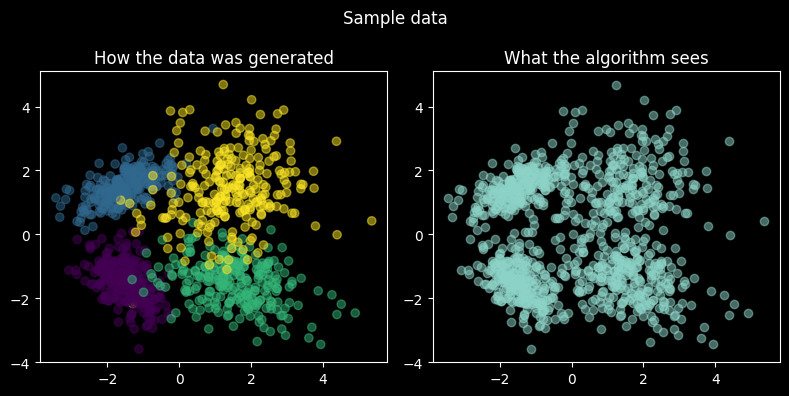

In [21]:
X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1,
                           shuffle=False, class_sep=1.5)

# Or, to use just 2 dimensions:
# X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1,
#                            shuffle=False, class_sep=1.5, n_features=2,
#                            n_informative=2, n_redundant=0, n_repeated=0)

print(f"X: {X.shape}\ny: {y.shape}")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=100)
axs[0].scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
axs[0].set_title('How the data was generated')
axs[1].scatter(X[:, 0], X[:, 1], alpha=0.5)
axs[1].set_title('What the algorithm sees')
fig.suptitle('Sample data')
plt.tight_layout()
plt.show()

Best round: 5


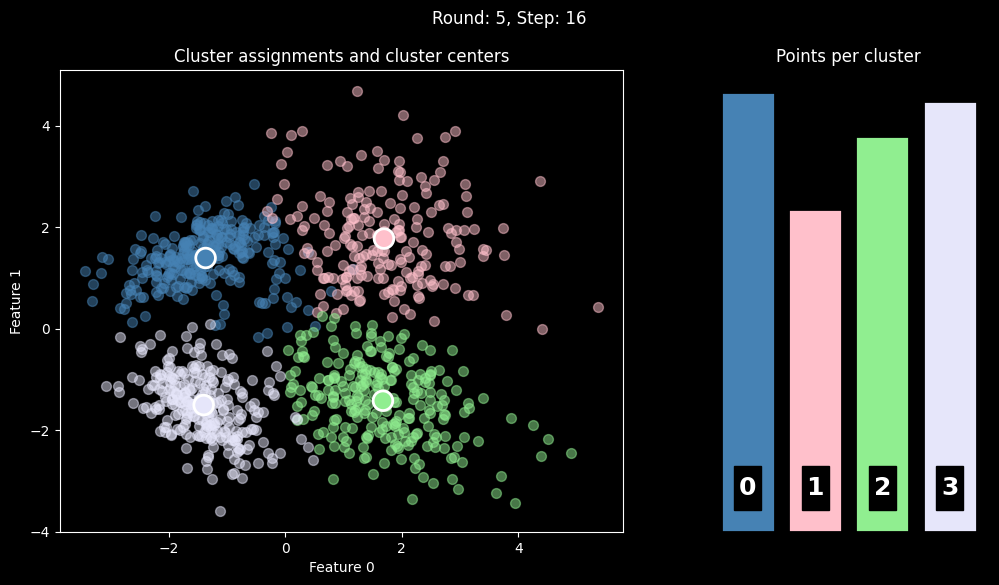

In [22]:
kmeans = KMeans(k=4, verbose=False, save_hist=True)
kmeans.fit(X)
print(f"Best round: {kmeans.best_round_}")

kmeans.plot_scatter(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    show_boundary_lines=False, show_cluster_regions=False, dpi=100)

# For animation:
# kmeans.plot_animate(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
#                     show_boundary_lines=True, show_cluster_regions=False,
#                     fps=1.0)

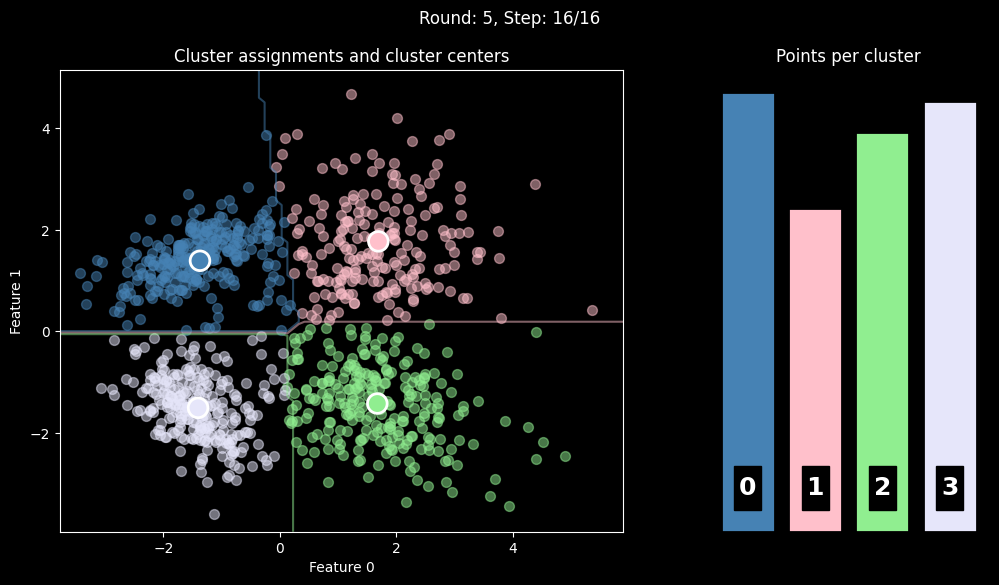

In [23]:
kmeans.plot_animate(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    show_boundary_lines=True, show_cluster_regions=False,
                    fps=1.0, dpi=100)

## Color palette generation from image

In [24]:
def download_img(url: str, reduced_img_max_size: int=128) -> np.ndarray:
    '''Download an image from a given URL and return it as a NumPy array.
    
    Returns a tuple of: (img_array, small_img_array) where `small_img_array` is
    a reduced-size version of `img_array` such that the longest dimension
    (height or width) of `img_array` is set to `reduced_img_max_size` pixels,
    with the shorter dimension adjusted proportionately.

    The `small_img_array` is used to speed up computation when fitting the
    KMeans classifier, while the `img_array` is used for displaying the image.
    '''
    # Reference: https://stackoverflow.com/questions/40911170/python-how-to-read-an-image-from-a-url/40911414#40911414
    with urllib.request.urlopen(url) as image_file:
        img = Image.open(image_file)
        # Resize the image so the longest side has 128 pixels, thus reducing computation time. See: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize
        dims = np.array(img.size)  # width, height
        factor = np.max(dims / reduced_img_max_size)  # reduction factor
        # Use the LANZCOS method for best resampling quality. See: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-filters
        img_small = img.resize(tuple((dims // factor).astype(int)), resample=Image.Resampling.LANCZOS)
        
        # Alternative method, using default resampling options. See: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.reduce
        # This sets the longest side to ~128 pixels, but not exactly.
        # img_small = img.reduce(factor = int(factor))
    return np.array(img), np.array(img_small)

Shape of image: (1872, 2000, 3)
For computational speed, image resized to (119, 128, 3)


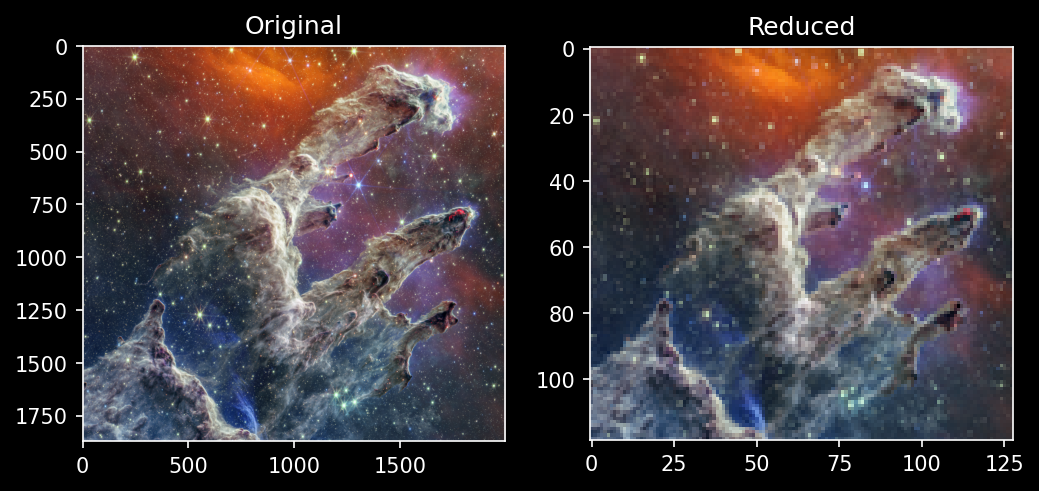

In [144]:
sample_images = [
    'https://yongsungkimart.com/cdn/shop/products/YK1010323_221d11a0-9a07-4fd6-add5-92a10dd9b6dc_1024x1024@2x.jpg?v=1645570775',  # 0, Dancing on the Water
    'https://stsci-opo.org/STScI-01GK2KPEFXG7M98JC28RXS66CZ.png',  # 1, Pillars of Creation
    'https://stsci-opo.org/STScI-01H2TX9WR52CVQRENNEN8GTRVF.jpg',  # 2, Orion Belt
    'https://stsci-opo.org/STScI-01GA6KNV1S3TP2JBPCDT8G826T.png',  # 3, Cosmic Cliffs of the Carina Nebula
    'https://stsci-opo.org/STScI-01G8H4DRM2C010PX6T3DPEEDAW.png',  # 4, Stephan's Quintet
    'https://stsci-opo.org/STScI-01GQ5CHESABWMHRF5NA60A6MPF.png',  # 5, Chamaeleon Molecular Cloud
    'https://matplotlib.org/stable/_images/sphx_glr_contour_001_2_0x.png',  # 6, Simple contour plot (tons of same-color pixels, making it a difficult case when clustering)
    'https://hips.hearstapps.com/hmg-prod/images/2024-volkswagen-atlas-126-1675887252.jpg?crop=0.702xw:0.592xh;0.160xw,0.240xh&resize=1200:*'  # 7, Volkswagen Atlas
]

img_array, small_img_array = download_img(sample_images[1])
print(f"Shape of image: {img_array.shape}")
print(f"For computational speed, image resized to {small_img_array.shape}")

hsv_array = mcolors.rgb_to_hsv(img_array[:, :, :3] / 255)  # ensure RGBA uses just RGB and that the values are in the range [0, 1]
small_hsv_array = mcolors.rgb_to_hsv(small_img_array[:, :, :3])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=150)
axs[0].imshow(img_array)
axs[0].set_title('Original')
axs[1].imshow(small_img_array)
axs[1].set_title('Reduced')
plt.show()

Train the K-Means classifier on two versions of the image: one in RGB (standard format), the other in HSV

In [162]:
kmeans = KMeans(k=4, verbose=False, save_hist=True)
kmeans.fit(small_img_array, unique_start=True)
print(f"Best round: {kmeans.best_round_}")

kmeans_hsv = KMeans(k=4, verbose=False, save_hist=True)
kmeans_hsv.fit(small_hsv_array, unique_start=True)
print(f"Best round: {kmeans_hsv.best_round_}")

Best round: 8
Best round: 7


In [163]:
print(f"Cluster centers using RGB color space:\n(red, green, blue)\n{kmeans.centers_.round(0)}")
with np.printoptions(formatter={'all': lambda x: f"{x:.2f}"}):
    print(f"\nCluster centers using HSV color space:\n(value, saturation, hue)\n{kmeans_hsv.centers_}")

Cluster centers using RGB color space:
(red, green, blue)
[[ 57.  54.  64.]
 [166. 161. 159.]
 [156.  76.  46.]
 [101.  94. 108.]]

Cluster centers using HSV color space:
(value, saturation, hue)
[[0.16 0.11 162.70]
 [0.72 0.30 92.84]
 [0.05 0.74 164.78]
 [0.03 0.36 102.40]]


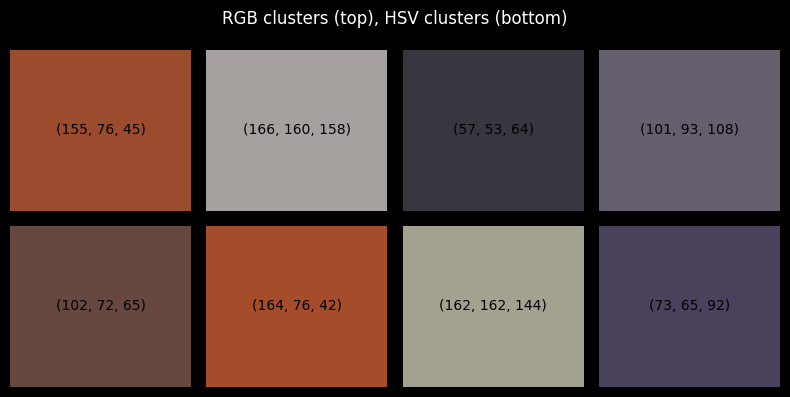

In [164]:
rgb_ver = kmeans.centers_
rgb_ver = np.array(sorted(rgb_ver, key=lambda c: tuple(mcolors.rgb_to_hsv(c)))) # Sort in HSV color mode
# rgb_ver = np.array(sorted(rgb_ver, key=lambda c: tuple(c)))  # Sort in RGB color mode

hsv_ver = mcolors.hsv_to_rgb(kmeans_hsv.centers_)  # Values range from 0-255
hsv_ver = np.array(sorted(hsv_ver, key=lambda c: tuple(mcolors.rgb_to_hsv(c))))  # Sort in HSV color mode
# hsv_ver = np.array(sorted(hsv_ver, key=lambda c: tuple(c)))  # Sort in RGB color mode

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4), dpi=100)

for row in range(rgb_ver.shape[0]):
    axs[0, row].add_patch(Rectangle((0, 0), 100, 100, color=tuple(rgb_ver[row, :] / 255)))
    axs[0, row].text(0.5, 0.5, tuple(rgb_ver[row, :].astype(np.uint8)), color='black', transform=axs[0, row].transAxes, ha='center', va='center')
    axs[0, row].axis('off')
    axs[1, row].add_patch(Rectangle((0, 0), 100, 100, color=tuple(hsv_ver[row, :] / 255)))
    axs[1, row].text(0.5, 0.5, tuple(hsv_ver[row, :].astype(np.uint8)), color='black', transform=axs[1, row].transAxes, ha='center', va='center')
    axs[1, row].axis('off')

fig.suptitle('RGB clusters (top), HSV clusters (bottom)')
plt.tight_layout()
plt.show()

Labeled image: (1872, 2000)


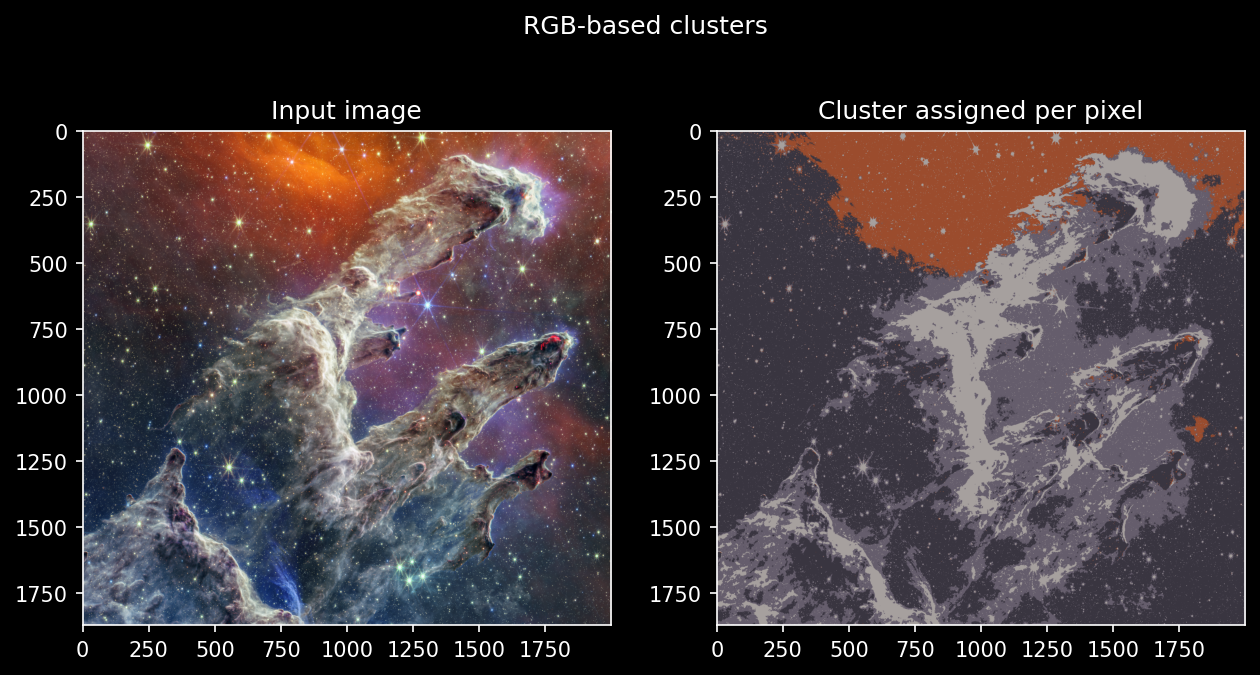

In [165]:
labels = kmeans.classify(img_array)
# labels = kmeans_hsv.classify(hsv_array)
print(f"Labeled image: {labels.shape}")

# Use the same cluster colors as the scatter plots
# palette = np.array([
#     [70, 130, 180],  # steelblue; ref: (np.array(mcolors.to_rgb(mcolors.CSS4_COLORS['steelblue'])) * 255).astype(np.uint8).tolist()
#     [255, 192, 203],  # pink
#     [144, 238, 144],  # lightgreen
#     [230, 230, 250],  # lavender
# ])

# Use the actual cluster colors
palette = kmeans.centers_.astype(np.uint8)

pixel_classification = palette[labels]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)
axs[0].imshow(img_array)
axs[1].imshow(pixel_classification)
axs[0].set_title('Input image')
axs[1].set_title('Cluster assigned per pixel')
fig.suptitle('RGB-based clusters')
plt.show()

Labeled image: (1872, 2000)


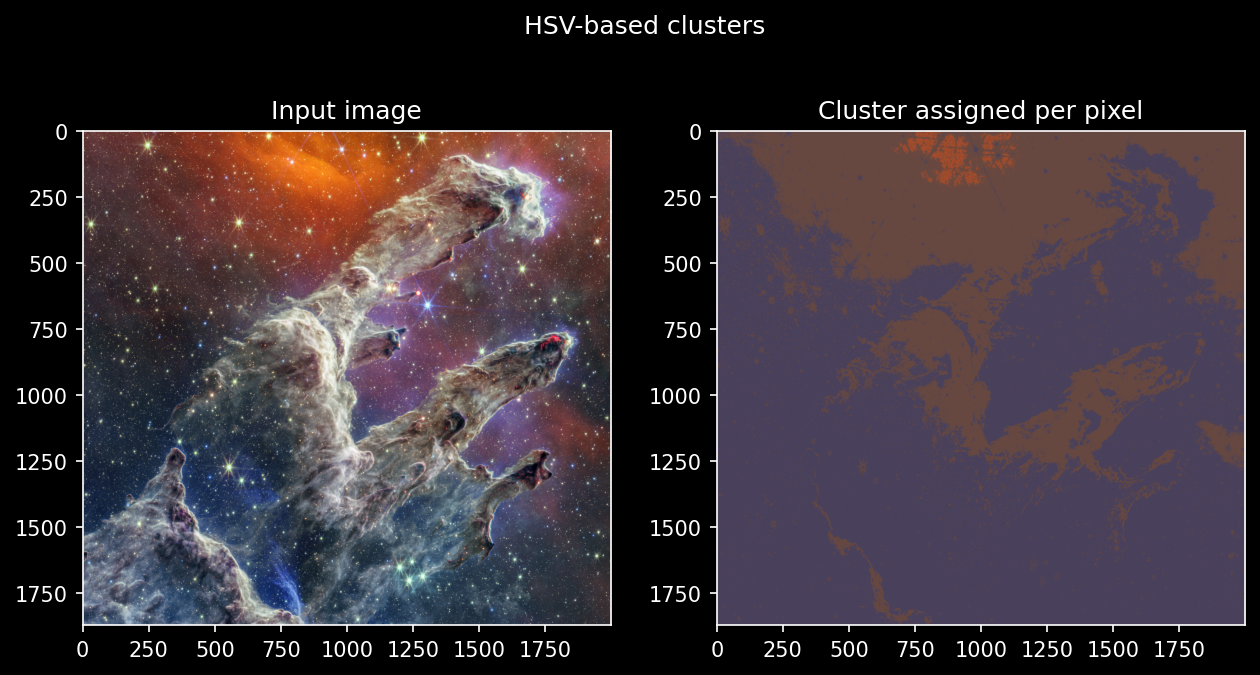

In [166]:
labels = kmeans_hsv.classify(hsv_array)
print(f"Labeled image: {labels.shape}")

# Use the same cluster colors as the scatter plots
# palette = np.array([
#     [70, 130, 180],  # steelblue; ref: (np.array(mcolors.to_rgb(mcolors.CSS4_COLORS['steelblue'])) * 255).astype(np.uint8).tolist()
#     [255, 192, 203],  # pink
#     [144, 238, 144],  # lightgreen
#     [230, 230, 250],  # lavender
# ])

# Use the actual cluster colors
palette = mcolors.hsv_to_rgb(kmeans_hsv.centers_).astype(np.uint8)

pixel_classification = palette[labels]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)
axs[0].imshow(img_array)
axs[1].imshow(pixel_classification)
axs[0].set_title('Input image')
axs[1].set_title('Cluster assigned per pixel')
fig.suptitle('HSV-based clusters')
plt.show()

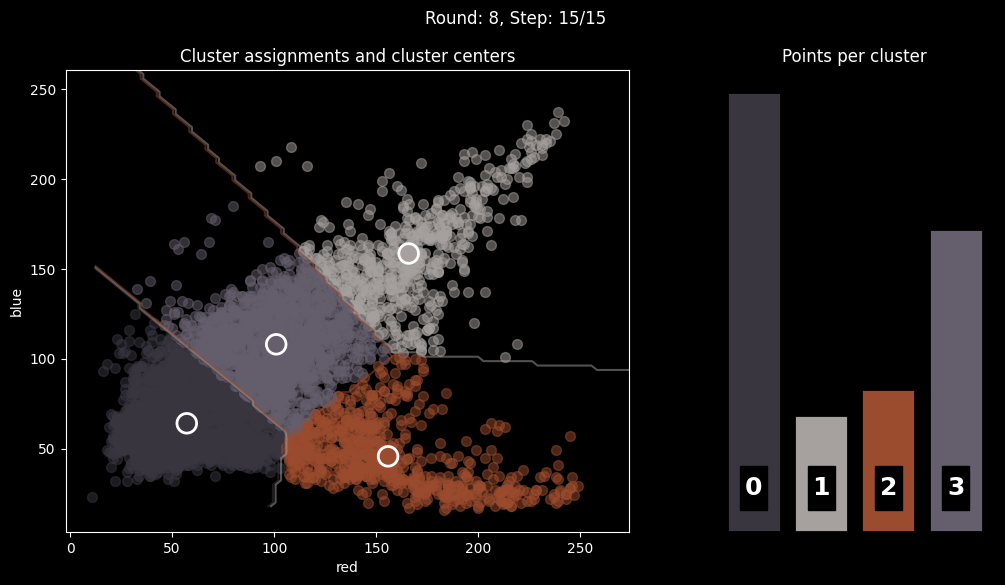

In [167]:
# RGB version
# kmeans.plot_scatter(small_img_array, colors='image',  # ['steelblue', 'pink', 'lightgreen', 'lavender'],
#                     features_selected=[0, 2], feature_names=['red', 'blue'],
#                     show_boundary_lines=True, show_cluster_regions=False,
#                     dpi=100)

# For animation:
kmeans.plot_animate(small_img_array, colors='image',  # ['steelblue', 'pink', 'lightgreen', 'lavender'],
                    features_selected=[0, 2], feature_names=['red', 'blue'],
                    show_boundary_lines=True, show_cluster_regions=False,
                    fps=1.0, dpi=100)

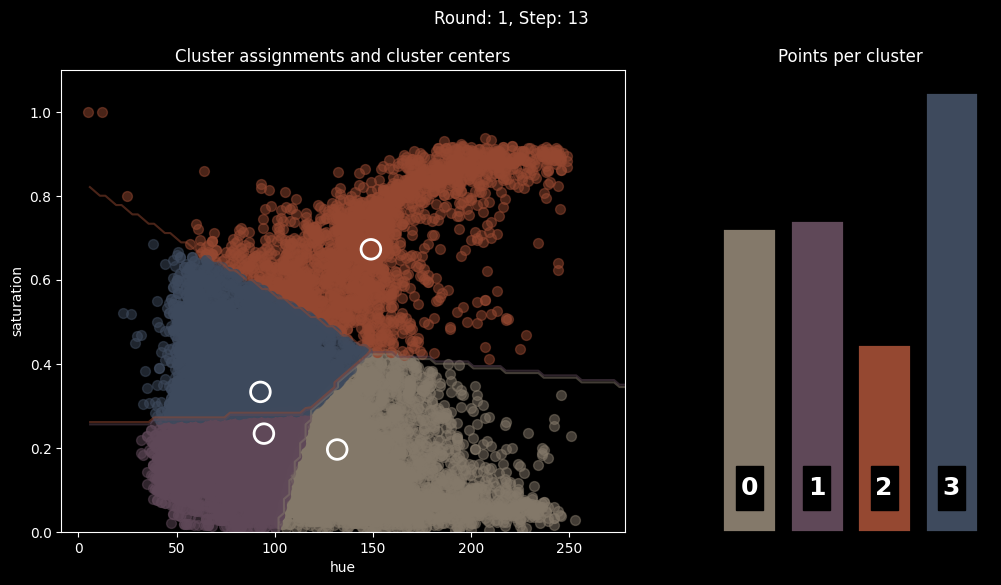

In [124]:
# HSV version
# kmeans_hsv.plot_scatter(small_hsv_array, colors=(mcolors.hsv_to_rgb(kmeans_hsv.centers_) / 255).tolist(),  # ['steelblue', 'pink', 'lightgreen', 'lavender'],
#                     features_selected=[2, 1], feature_names=['hue', 'saturation'],
#                     show_boundary_lines=True, show_cluster_regions=False,
#                     dpi=100)

# For animation:
kmeans_hsv.plot_animate(small_hsv_array, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    features_selected=[2, 1], feature_names=['hue', 'saturation'],
                    show_boundary_lines=True, show_cluster_regions=False,
                    fps=1.0, dpi=100)

### Top _n_ clusters
For color palette generation, it can be better to set the number of clusters to 3-4x the number of colors for the palette, then sort those clusters to those that are the most prominent and most cohesive (that is, the largest clusters with the smallest mean distance between cluster points and the cluster center).

In [168]:
def choose_clusters(
        data: np.ndarray,
        kmeans: KMeans,
        num: int = 5) -> np.ndarray:
    '''Select a subset of the clusters from a trained KMeans classifier.

    Clusters are ranked by this formula:
    (% total data points in cluster) ÷ (mean distance of cluster / mean distance of all clusters)

    For example:
    - A dataset has 1,000 points.
    - 150 of those points are labeled with cluster 0
    - Cluster 0 has a mean distance of 0.075
    - The mean of mean distances across all clusters is 0.10
    Cluster 0 score = (150 / 1000) / (0.075 / 0.10) = 0.15 / 0.75 = 0.20
    In this example, Cluster 0 is scored 20%, which will then be compared with
    the scores of all other clusters, then sorted in descending order, with the
    top `num` clusters returned.
    
    # Parameters
    `data`: np.ndarray
        The data to be used for selecting the top clusters. This will likely be
        the data on which the `KMeans` classifier was trained. This is used to
        compute the distribution of poitns among clusters for ranking.
    `kmeans`: a trained instance of the `KMeans` class
        The trained KMeans classifier.
    `num`: int, default=5
        The number of clusters to return; a subset of the clusters trained by
        the `KMeans` classifer. A good rule of thumb is to set `num` to 1/3
        or 1/4 of the number of clusters trained by the `KMeans` classifier,
        for example, if the `KMeans` classifer has 20 clusters,
        `num` could be 5-7.
        If `None`, then the number of clusters returned will be 1/3 of the
        number of clusters trained by the `KMeans` classifier.
        If `num` is greater than or equal to the number of clusters trained by
        the classifier, then this function will return all clusters, ranked by
        the sorting function given above.
    '''
    # Ensure that the number of clusters returned does not exceed the total number of clusters
    if num > len(kmeans.centers_):
        num = len(kmeans.centers_)
    if num == None:
        num = len(kmeans.centers_) // 3
    labels = kmeans.classify(data, preserve_input_shape=False)
    counts = np.bincount(labels)
    # Use weighting factors to balance between cluster size (larger is better) and avg. distance (smaller is better)
    scores = (counts / counts.max()) + (kmeans.distances_.min() / kmeans.distances_)

    # Alternative calculation that magnifies (or reduces) cluster size based on cluster cohesiveness
    # % of total data points / difference from mean (less than mean is <1, above mean is >1)
    # scores = (counts / counts.sum()) / (kmeans.distances_ / kmeans.distances_.mean())
    cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
    return kmeans.centers_[cluster_indices[:num], :]

In [201]:
choose_clusters(data=small_img_array, kmeans=kmeans, num=4).round()

array([[ 39.,  44.,  55.],
       [ 75.,  54.,  56.],
       [ 50.,  63.,  82.],
       [101.,  79.,  89.]])

In [172]:
# Matplotlib returns RGB (and HSV) normalized to the range [0, 1]

# mcolors.rgb_to_hsv(mcolors.to_rgba_array(mcolors.CSS4_COLORS.values())[:, :3])[:2]
mcolors.to_rgba_array(mcolors.CSS4_COLORS.values())[:2, :]

array([[0.94117647, 0.97254902, 1.        , 1.        ],
       [0.98039216, 0.92156863, 0.84313725, 1.        ]])

### Closest named colors

In [196]:
def find_nearest_named_colors(
        kmeans: KMeans,
        centers: np.ndarray | None = None,
        color_name_list: str='css4',
        color_space: str='rgb',
        comparison_color_space: str='rgb') -> dict:
    '''Return a dictionary with the nearest named colors and their RGB values
    
    # Parameters
    `kmeans`: instance of the KMeans class
        Must have already been trained on data using the .fit() method. Used
        for normalizing input data to the range [0, 1], which is used internally
        by Matplotlib.
    `centers`: np.ndarray
        The cluster centers. If not provided (default), `kmeans.centers_` will
        be used.
    `color_name_list`: {'css4', 'xkcd'}, default='css4'
        The color names (and associated hex values) to use. CSS4 colors are
        standard on the web, and XKCD colors come from the XKCD color survey.
        There are 148 CSS4 colors and 954 XKCD colors.
    `color_space`: {'rgb', 'hsv'}, default='rgb'
        The color space used when training the KMeans classifier.
    `comparison_color_space`: {'rgb', 'hsv'}, default='rgb'
        The color space to use when finding the nearest named color to each
        cluster center, irrespective of the color space the KMeans classifier
        was trained on.
        Using Eucliedean distance, HSV color space tends to be more accurate
        at finding perceptually similar colors than the RGB color space.
    '''
    # Use the cluster centers from the KMeans classifier if none are provided
    if not np.any(centers):
        centers = kmeans.centers_

    if color_name_list == 'xkcd':
        color_dict = mcolors.XKCD_COLORS
    else:
        color_dict = mcolors.CSS4_COLORS  # or, mcolors.cnames

    # Trim the alpha component using slicing to omit the 4th column: ([:, :3])
    rgb_named_colors = (mcolors.to_rgba_array(color_dict.values())[:, :3])  # Values are in the range [0, 1]
    
    # Use HSV colors to better match color perception. Inspired by: https://matplotlib.org/stable/gallery/color/named_colors.html#helper-function-for-plotting
    # The returned HSV values are normalized to the range [0, 1]
    hsv_named_colors = mcolors.rgb_to_hsv(mcolors.to_rgba_array(color_dict.values())[:, :3])
    
    if color_space == 'hsv':
        hsv_centers = kmeans._preprocess(centers, normalize=True)
        rgb_centers = mcolors.hsv_to_rgb(kmeans._preprocess(centers, normalize=True))
    else:
        hsv_centers = mcolors.rgb_to_hsv(centers / 255)
        rgb_centers = centers / 255
    
    if comparison_color_space == 'hsv':
        distances = (hsv_centers[..., np.newaxis] - hsv_named_colors.T[np.newaxis, ...]) ** 2
    else:
        distances = (rgb_centers[..., np.newaxis] - rgb_named_colors.T[np.newaxis, ...]) ** 2

    # .sum(axis=1) finds the distance from each cluster center to each named color, returns a 2d array: (num_clusters, num_named_colors)
    # .argmin(axis=1) finds the closest named, returns a 1d array: (num_clusters,)
    nearest_named_colors = distances.sum(axis=1).argmin(axis=1)

    return_dict = {}
    for i in range(len(nearest_named_colors)):
        color_idx = nearest_named_colors[i]
        return_dict[i] = {'name': list(color_dict.keys())[color_idx], 'rgb': (rgb_named_colors[color_idx, :] * 255).astype(np.uint8)}
    return return_dict


find_nearest_named_colors(kmeans, color_space='rgb', comparison_color_space='hsv')

{0: {'name': 'sienna', 'rgb': array([160,  82,  45], dtype=uint8)},
 1: {'name': 'darkslategray', 'rgb': array([47, 79, 79], dtype=uint8)},
 2: {'name': 'slategray', 'rgb': array([112, 128, 144], dtype=uint8)},
 3: {'name': 'darkgray', 'rgb': array([169, 169, 169], dtype=uint8)}}

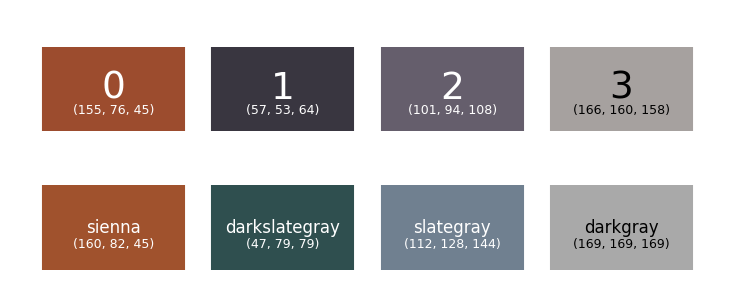

In [197]:
cluster_colors = kmeans.centers_
nearest_colors = find_nearest_named_colors(
    kmeans,
    color_space='rgb',
    comparison_color_space='hsv')
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 2), dpi=150)

for n, (cluster_num, color_dict) in enumerate(nearest_colors.items()):
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (cluster_colors[n, 0] / 255) + 0.587 * (cluster_colors[n, 1] / 255) + 0.114 * (cluster_colors[n, 2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[0].add_patch(Rectangle(xy=((n * 24) + 4, 0), width=20, height=100, color=tuple(cluster_colors[n] / 255)))
    axs[0].text(x=(n * 24) + 14, y=50, s=n, color=font_color, fontdict={'fontsize': 18}, ha='center', va='center')
    axs[0].text(x=(n * 24) + 14, y=25, s=tuple(cluster_colors[n].astype(np.uint8)), color=font_color, fontdict={'fontsize': 6}, ha='center', va='center')

    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (color_dict['rgb'][0] / 255) + 0.587 * (color_dict['rgb'][1] / 255) + 0.114 * (color_dict['rgb'][2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[1].add_patch(Rectangle(xy=((n * 24) + 4, 0), width=20, height=100, color=tuple(color_dict['rgb'] / 255)))
    axs[1].text(x=(n * 24) + 14, y=50, s=color_dict['name'], color=font_color, fontdict={'fontsize': 8}, ha='center', va='center')
    axs[1].text(x=(n * 24) + 14, y=30, s=tuple(color_dict['rgb']), color=font_color, fontdict={'fontsize': 6}, ha='center', va='center')

for ax in axs:
    ax.set_axis_off()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
fig.set_facecolor('none')
axs[0].set_title('Clusters')
axs[1].set_title('Closest named colors')

plt.tight_layout()
plt.show()

### Color palette

In [198]:
kmeans = KMeans(k=12, verbose=False, save_hist=True)
kmeans.fit(small_img_array, unique_start=True)
print(f"Best round: {kmeans.best_round_}")

# kmeans_hsv = KMeans(k=12, verbose=False, save_hist=True)
# kmeans_hsv.fit(small_hsv_array, unique_start=True)
# print(f"Best round: {kmeans_hsv.best_round_}")

Best round: 9


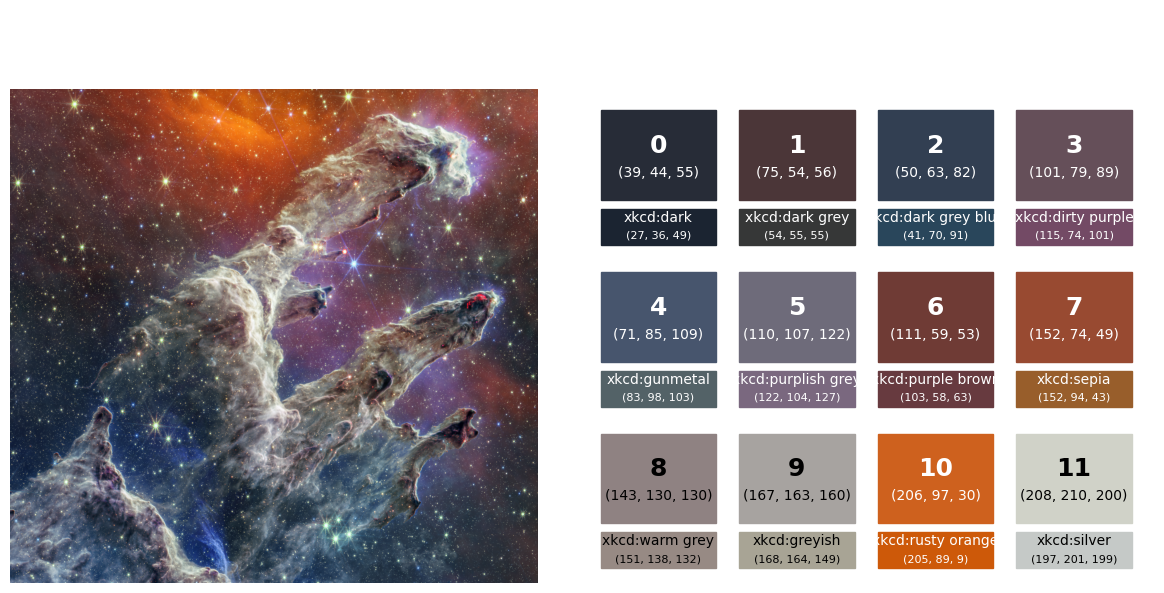

In [211]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=100)

# For KMeans trained on RGB data
# cluster_colors = kmeans.centers_
cluster_colors = choose_clusters(data=small_img_array, kmeans=kmeans, num=12)
nearest_colors = find_nearest_named_colors(
    kmeans,
    centers = cluster_colors,
    color_name_list='xkcd',
    color_space='rgb',
    comparison_color_space='rgb')

# For KMeans trained on HSV data
# cluster_colors = np.round(
#     mcolors.hsv_to_rgb(
#         kmeans_hsv._preprocess(kmeans_hsv.centers_, normalize=True)) * 255
#     ).astype(np.uint8)
# nearest_colors = find_nearest_named_colors(
#     kmeans_hsv,
#     color_name_list='css4',
#     color_space='hsv',
#     comparison_color_space='hsv')

w, h = axs[1].get_window_extent().width, axs[1].get_window_extent().height
w, h = 100, (h/w) * 100  # Set width to 100 and height to be proportional to maintain a square grid

swatch_size = 20  # max of 4 colums in a 100-unit space, with padding between each
padding = 4
# num_patches = len(kmeans.centers_)
num_patches = len(kmeans_hsv.centers_)
nrows = np.ceil(num_patches / 4)
y_start = (h - 24)

for n, (cluster_num, color_dict) in enumerate(nearest_colors.items()):
    # Determine the row number
    row_num = np.ceil((n + 1) / 4) 
    # Determine whether the swatch is in the last row
    if row_num == nrows:
        if num_patches % 4 == 0:
            x_start = 4
        else:
            x_start = 4 + ((4 - (num_patches % 4)) * 12)  # based on number of swatches in the row
    else:
        x_start = 4
    axs[1].add_patch(
        Rectangle(
            xy=(x_start + ((n % 4) * 24), y_start - ((row_num - 1) * 36)),
            width=20,
            height=20,
            color=tuple(cluster_colors[n] / 255)))
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (cluster_colors[n, 0] / 255) + 0.587 * (cluster_colors[n, 1] / 255) + 0.114 * (cluster_colors[n, 2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) + 12,
        s=n,
        color=font_color,
        fontdict={'fontsize': 18, 'fontweight': 'bold'},
        ha='center', va='center')
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) + 6,
        s=tuple(np.round(cluster_colors[n]).astype(np.uint8)),
        color=font_color,
        fontdict={'fontsize': 10, 'fontweight': 'normal'},
        ha='center', va='center')

    # Nearest named color
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (color_dict['rgb'][0] / 255) + 0.587 * (color_dict['rgb'][1] / 255) + 0.114 * (color_dict['rgb'][2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[1].add_patch(
        Rectangle(
            xy=(x_start + ((n % 4) * 24), y_start - ((row_num - 1) * 36) - 10),
            width=20,
            height=8,
            color=tuple(color_dict['rgb'] / 255)))
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) - 4,
        s=color_dict['name'],
        color=font_color,
        fontdict={'fontsize': 10},
        ha='center', va='center')
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) - 8,
        s=tuple(color_dict['rgb']),
        color=font_color,
        fontdict={'fontsize': 8},
        ha='center', va='center')

axs[1].set_axis_off()
axs[1].set_xlim(0, w)
axs[1].set_ylim(0, h)
axs[1].set_xticks(ticks=np.arange(start=0, stop=w, step=10))
axs[1].set_yticks(ticks=np.arange(start=0, stop=h + 1, step=10))
axs[1].grid(visible=False)
axs[1].set_title('Color palette\n(with closest named color below)')

axs[0].imshow(img_array)
axs[0].set_title('Input')
axs[0].set_axis_off()

fig.set_facecolor('none')
fig.suptitle('KMeans: Image → Color palette', fontdict={'size': 24, 'weight': 'light'})
plt.tight_layout()
plt.show()

### Scoring calculation
**Experiments with different scoring calculations to rank clusters for color palette generation.**

The chosen palette should represent the image well, while also including some of the accent colors of the image.

See the plot below to match the cluster indices to the colors and get an idea of how clusters would be chosen (for n=4, the leftmost 4 clusters would be chosen from the lines `Cluster indices`)

In [250]:
labels = kmeans.classify(small_img_array, preserve_input_shape=False)
counts = np.bincount(labels)

print('Counts:\n', np.arange(counts.shape[0]).tolist(), '\n', counts, sep='')
print('Largest -> Smallest: ', np.argsort(counts)[::-1], '\n', sep='')  # sort in descending order

print('Distances:\n', kmeans.distances_.round(3), sep='')
print('Smallest -> Largest: ', np.argsort(kmeans.distances_), '\n', sep='')

scores = (counts / counts.sum()) / (kmeans.distances_ / kmeans.distances_.mean())
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: Pct of total data points / pct. distance above mean\n', scores.round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (1 - np.abs((counts - counts.mean()) / counts.mean()).round(3))
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: cluster size (mean is best at 1)\n', scores.round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (counts / counts.max())
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: cluster size (largest is best at 1)\n', scores.round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (kmeans.distances_.min() / kmeans.distances_)
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: distance (smallest is best at 1)\n', scores.round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (1 - np.abs((kmeans.distances_ - kmeans.distances_.mean()) / kmeans.distances_.mean()).round(3))
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: distance (mean is best at 1)\n', scores.round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (counts / counts.max()) + (kmeans.distances_.min() / kmeans.distances_)
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: largest size and smallest dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (1 - np.abs((counts - counts.mean()) / counts.mean()).round(3)) + (1 - np.abs((kmeans.distances_ - kmeans.distances_.mean()) / kmeans.distances_.mean()).round(3))
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: avg. size and avg. dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (1 - np.abs((counts - counts.mean()) / counts.mean()).round(3)) + (kmeans.distances_.min() / kmeans.distances_)
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: avg. size and smallest dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (counts.min() / counts) + (kmeans.distances_.min() / kmeans.distances_)
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: smallest size and smallest dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (counts.min() / counts) + (1 - np.abs((kmeans.distances_ - kmeans.distances_.mean()) / kmeans.distances_.mean()).round(3))
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: smallest size and avg. dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')

scores = (counts.min() / counts) + (kmeans.distances_ / kmeans.distances_.max())
cluster_indices = np.argsort(scores)[::-1]  # sort in descending order
print('Scores: smallest size and largest dist. (best=1)\n', (scores / 2).round(3), sep='')
print('Cluster indices:\n', cluster_indices, '\n', sep='')


# Use weighting factors to balance between cluster size (larger is better) and avg. distance (smaller is better)
# scores = (0.7 * count_scores) + (0.3 * distance_scores)

Counts:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[ 480 2381 1139 1736 1838  340 1246 1547  738 1065  949 1773]
Largest -> Smallest: [ 1  4 11  3  7  6  2  9 10  8  0  5]

Distances:
[0.094 0.055 0.097 0.062 0.056 0.099 0.067 0.087 0.092 0.087 0.061 0.073]
Smallest -> Largest: [ 1  4 10  3  6 11  9  7  8  0  2  5]

Scores: Pct of total data points / pct. distance above mean
[0.026 0.219 0.06  0.143 0.167 0.018 0.095 0.09  0.041 0.062 0.079 0.124]
Cluster indices:
[ 1  4  3 11  6  7 10  9  2  8  0  5]

Scores: cluster size (mean is best at 1)
[0.378 0.124 0.897 0.632 0.552 0.268 0.982 0.781 0.581 0.839 0.748 0.603]
Cluster indices:
[ 6  2  9  7 10  3 11  8  4  0  5  1]

Scores: cluster size (largest is best at 1)
[0.202 1.    0.478 0.729 0.772 0.143 0.523 0.65  0.31  0.447 0.399 0.745]
Cluster indices:
[ 1  4 11  3  7  6  2  9 10  8  0  5]

Scores: distance (smallest is best at 1)
[0.586 1.    0.569 0.893 0.984 0.561 0.827 0.633 0.601 0.635 0.902 0.758]
Cluster indices:
[ 1  4 10  3  6 11 

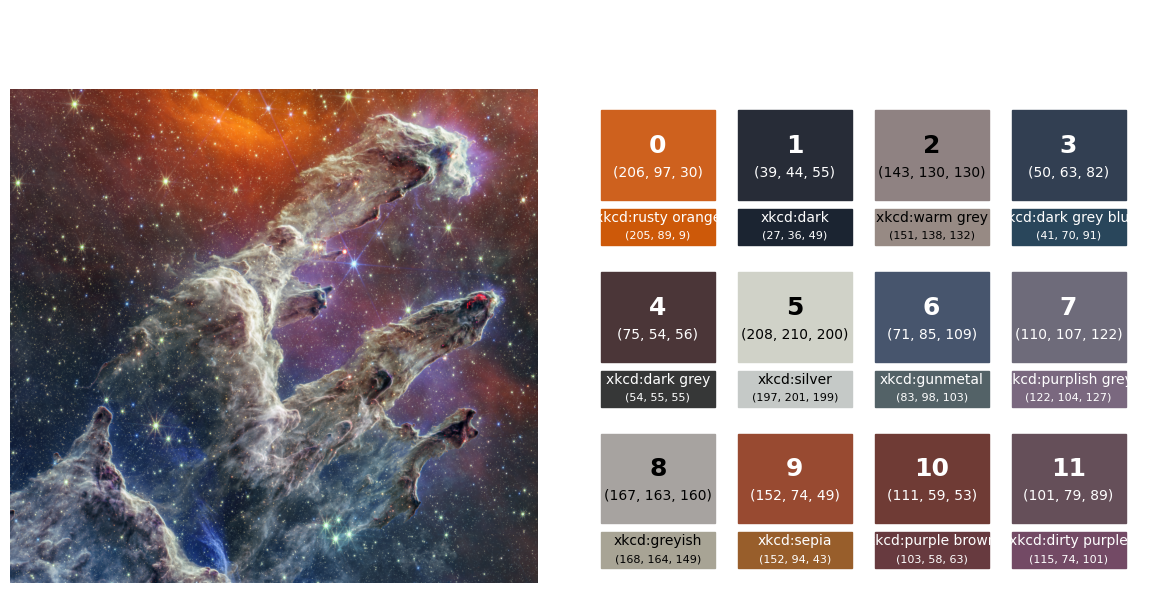

In [210]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=100)

# For KMeans trained on RGB data
cluster_colors = kmeans.centers_
# cluster_colors = choose_clusters(data=small_img_array, kmeans=kmeans, num=4)
nearest_colors = find_nearest_named_colors(
    kmeans,
    centers = cluster_colors,
    color_name_list='xkcd',
    color_space='rgb',
    comparison_color_space='rgb')

# For KMeans trained on HSV data
# cluster_colors = np.round(
#     mcolors.hsv_to_rgb(
#         kmeans_hsv._preprocess(kmeans_hsv.centers_, normalize=True)) * 255
#     ).astype(np.uint8)
# nearest_colors = find_nearest_named_colors(
#     kmeans_hsv,
#     color_name_list='css4',
#     color_space='hsv',
#     comparison_color_space='hsv')

w, h = axs[1].get_window_extent().width, axs[1].get_window_extent().height
w, h = 100, (h/w) * 100  # Set width to 100 and height to be proportional to maintain a square grid

swatch_size = 20  # max of 4 colums in a 100-unit space, with padding between each
padding = 4
# num_patches = len(kmeans.centers_)
num_patches = len(kmeans_hsv.centers_)
nrows = np.ceil(num_patches / 4)
y_start = (h - 24)

for n, (cluster_num, color_dict) in enumerate(nearest_colors.items()):
    # Determine the row number
    row_num = np.ceil((n + 1) / 4) 
    # Determine whether the swatch is in the last row
    if row_num == nrows:
        if num_patches % 4 == 0:
            x_start = 4
        else:
            x_start = 4 + ((4 - (num_patches % 4)) * 12)  # based on number of swatches in the row
    else:
        x_start = 4
    axs[1].add_patch(
        Rectangle(
            xy=(x_start + ((n % 4) * 24), y_start - ((row_num - 1) * 36)),
            width=20,
            height=20,
            color=tuple(cluster_colors[n] / 255)))
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (cluster_colors[n, 0] / 255) + 0.587 * (cluster_colors[n, 1] / 255) + 0.114 * (cluster_colors[n, 2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) + 12,
        s=n,
        color=font_color,
        fontdict={'fontsize': 18, 'fontweight': 'bold'},
        ha='center', va='center')
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) + 6,
        s=tuple(np.round(cluster_colors[n]).astype(np.uint8)),
        color=font_color,
        fontdict={'fontsize': 10, 'fontweight': 'normal'},
        ha='center', va='center')

    # Nearest named color
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (color_dict['rgb'][0] / 255) + 0.587 * (color_dict['rgb'][1] / 255) + 0.114 * (color_dict['rgb'][2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axs[1].add_patch(
        Rectangle(
            xy=(x_start + ((n % 4) * 24), y_start - ((row_num - 1) * 36) - 10),
            width=20,
            height=8,
            color=tuple(color_dict['rgb'] / 255)))
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) - 4,
        s=color_dict['name'],
        color=font_color,
        fontdict={'fontsize': 10},
        ha='center', va='center')
    axs[1].text(
        x=x_start + ((n % 4) * 24) + 10,
        y=y_start - ((row_num - 1) * 36) - 8,
        s=tuple(color_dict['rgb']),
        color=font_color,
        fontdict={'fontsize': 8},
        ha='center', va='center')

axs[1].set_axis_off()
axs[1].set_xlim(0, w)
axs[1].set_ylim(0, h)
axs[1].set_xticks(ticks=np.arange(start=0, stop=w, step=10))
axs[1].set_yticks(ticks=np.arange(start=0, stop=h + 1, step=10))
axs[1].grid(visible=False)
axs[1].set_title('Color palette\n(with closest named color below)')

axs[0].imshow(img_array)
axs[0].set_title('Input')
axs[0].set_axis_off()

fig.set_facecolor('none')
fig.suptitle('KMeans: Image → Color palette', fontdict={'size': 24, 'weight': 'light'})
plt.tight_layout()
plt.show()

Labeled image: (1872, 2000)


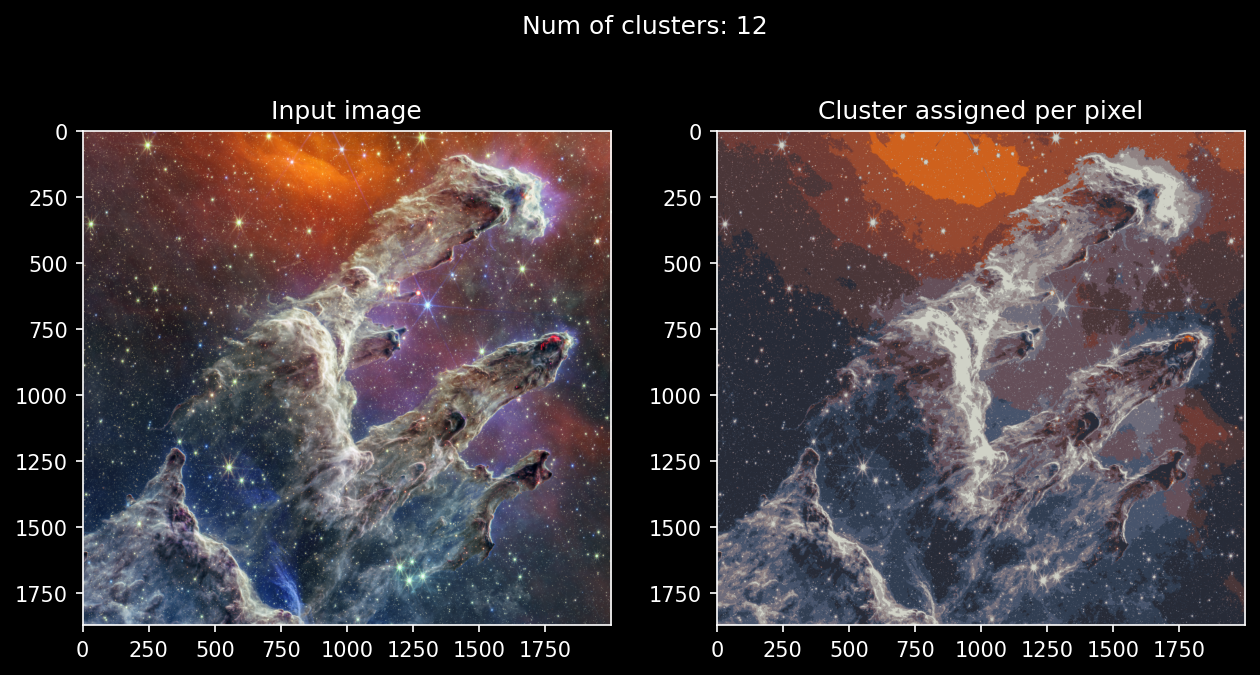

In [239]:
labels = kmeans.classify(img_array)
print(f"Labeled image: {labels.shape}")

# Use the actual cluster colors
palette = kmeans.centers_.astype(np.uint8)

pixel_classification = palette[labels]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)
axs[0].imshow(img_array)
axs[1].imshow(pixel_classification)
axs[0].set_title('Input image')
axs[1].set_title('Cluster assigned per pixel')
fig.suptitle(f"Num of clusters: {kmeans.k}")
plt.show()

**Layout test for color palette plotting**

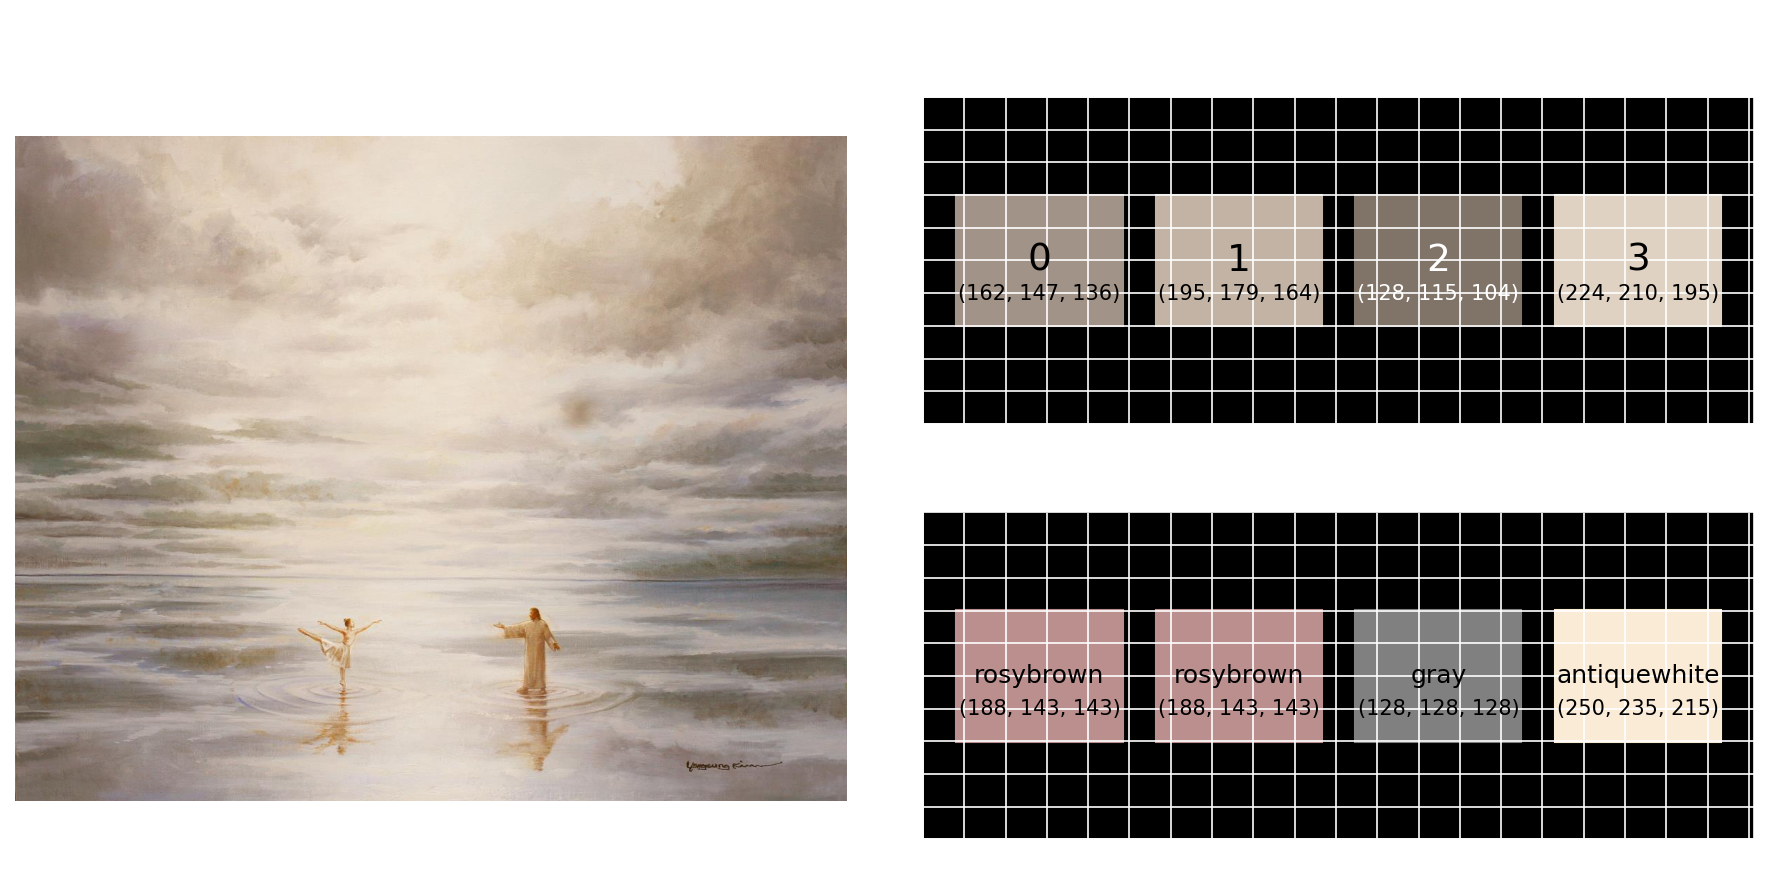

In [118]:
gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(12, 6),
                            #   layout='constrained',  # use plt.tight_layout() instead
                              dpi=150)
# cluster_colors = np.round((kmeans.centers_ * (kmeans.data_max_ - kmeans.data_min_)) + kmeans.data_min_).astype(np.uint8)
cluster_colors = np.round(kmeans.centers_).astype(np.uint8)
nearest_colors = find_nearest_named_colors(kmeans)

w, h = axd['upper right'].get_window_extent().width, axd['upper right'].get_window_extent().height
w, h = (w/h) * 100, 100

for n, (cluster_num, color_dict) in enumerate(nearest_colors.items()):
    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (cluster_colors[n, 0] / 255) + 0.587 * (cluster_colors[n, 1] / 255) + 0.114 * (cluster_colors[n, 2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axd['upper right'].add_patch(Rectangle(xy=((n * 0.24*w) + 0.04*w, 0.5*h - 0.2*w/2), width=0.2*w, height=0.2*w, color=tuple(cluster_colors[n] / 255)))
    axd['upper right'].text(x=(n * 0.24*w) + 0.14*w, y=0.50*h, s=n, color=font_color, fontdict={'fontsize': 18}, ha='center', va='center')
    axd['upper right'].text(x=(n * 0.24*w) + 0.14*w, y=0.40*h, s=tuple(cluster_colors[n]), color=font_color, fontdict={'fontsize': 10}, ha='center', va='center')

    # Choose text color based on perceived luminance. Calculation from: https://matplotlib.org/stable/tutorials/colors/colors.html#comparison-between-x11-css4-and-xkcd-colors
    luminance = 0.299 * (color_dict['rgb'][0] / 255) + 0.587 * (color_dict['rgb'][1] / 255) + 0.114 * (color_dict['rgb'][2] / 255)
    font_color = 'black' if luminance > 0.5 else 'white'
    axd['lower right'].add_patch(Rectangle(xy=((n * 0.24*w) + 0.04*w, 0.5*h - 0.2*w/2), width=0.2*w, height=0.2*w, color=tuple(color_dict['rgb'] / 255)))
    axd['lower right'].text(x=(n * 0.24*w) + 0.14*w, y=0.50*h, s=color_dict['name'], color=font_color, fontdict={'fontsize': 12}, ha='center', va='center')
    axd['lower right'].text(x=(n * 0.24*w) + 0.14*w, y=0.40*h, s=tuple(color_dict['rgb']), color=font_color, fontdict={'fontsize': 10}, ha='center', va='center')

for ax in ['upper right', 'lower right']:
    # axd[ax].set_axis_off()
    axd[ax].grid(visible=True)
    axd[ax].set_xticks(ticks=np.arange(start=0, stop=w, step=10))
    axd[ax].set_yticks(ticks=np.arange(start=0, stop=h + 1, step=10))
    axd[ax].set_xlim(0, w)
    axd[ax].set_ylim(0, h)

fig.set_facecolor('none')
axd['upper right'].set_title('Color palette')
axd['lower right'].set_title('Closest named colors')

axd['left'].imshow(img_array)
axd['left'].set_title('Input')
axd['left'].set_title('Input')
axd['left'].set_axis_off()

fig.suptitle('Image → Color palette using KMeans')
plt.tight_layout()
plt.show()

--- 

# K-Means, step by step
This section shows how the K-Means works, step by step, with comments explaining the vectorized operations.

In [185]:
k = 4  # Set the number of clusters

# Sample one point for each of the cluster centers
rng = np.random.default_rng()
centers = rng.choice(X, size=k, replace=False, shuffle=False)

print(f"Shape of cluster centers: {centers.shape}")
print(f"Transpose and add a row dimension for broadcasting: {centers.T[np.newaxis, :, :].shape}")

Shape of cluster centers: (4, 20)
Transpose and add a row dimension for broadcasting: (1, 20, 4)


In [194]:
# Add a cluster dimension (dim 3) to the X array to store the distance of each
# cluster center to the data point at each of the point's dimensions.
# Add a row dimension (dim 1) to the transposed centers array to broadcast down
# the rows of the X array.
distances = (X[..., np.newaxis] - centers.T[np.newaxis, ...])**2
# .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
# .argmin(axis=1) finds the closest cluster center, returns a 1d array
labels = distances.sum(axis=1).argmin(axis=1)

print(f"Shape of distances array: {distances.shape}")
print(f"Shape of labels array: {labels.shape}")

Shape of distances array: (1000, 20, 4)
Shape of labels array: (1000,)


The cell below uses vectorized operations to compute the new cluster means by indexing into the `X` array and computing the mean for each cluster across all the samples (rows) in `X`.

This is a loop equivalent:

```python
centers = []
for i in range(k):
    centers.append(X[labels==i].mean(axis=0))
```

In [195]:
# Create a boolean one-hot-encoding of the closest cluster center for each point
indices = np.eye(k, dtype='bool')[labels]
print(f"Shape of indices: {indices.shape}")

# Index the X array to compute the new mean based the cluster assignments
# cluster_assignments is a 3d array: (rows, columns, clusters), where dim 3 is
# 0s where the cluster was not assigned and equal to the column values at the
# assigned cluster.
cluster_assignments = (X[..., np.newaxis] * indices[:, np.newaxis, :])
centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
print(f"Shape of cluster centers: {centers.shape}")

Shape of indices: (1000, 4)
Shape of cluster centers: (4, 20)


## Visualize cluster assignments

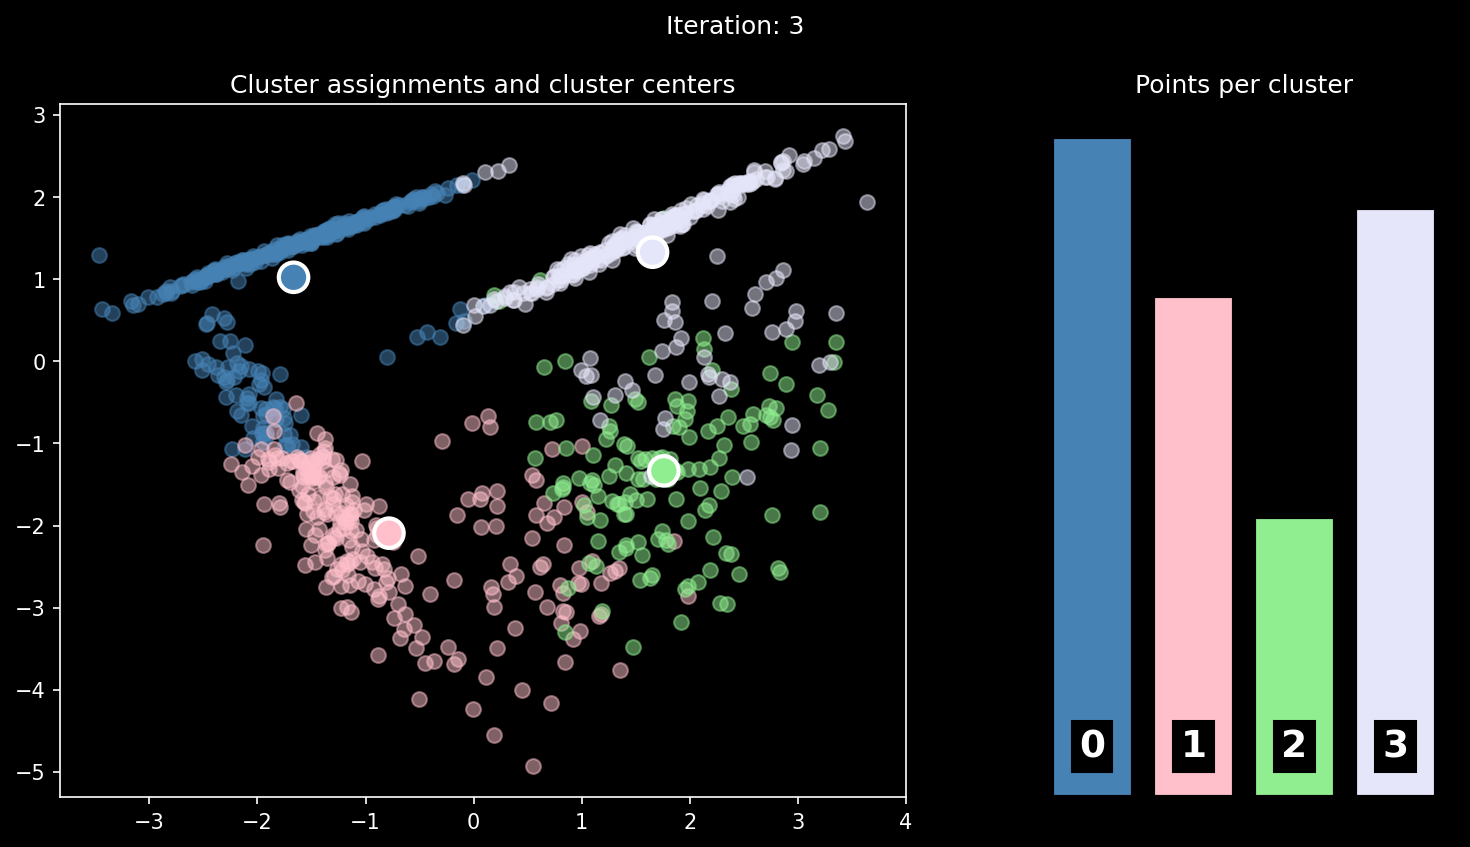

In [196]:
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

step_num = 3  # the iteration for the algorithm

# Select k random colors for plotting
rng = np.random.default_rng()
colors = rng.choice(list(mcolors.CSS4_COLORS.keys()), size=k, replace=False)
colors = ['steelblue', 'pink', 'lightgreen', 'lavender']

counts = np.eye(k, dtype='int')[labels].sum(axis=0)
for i in range(k):
    # Plot the points and their categories
    row_mask = (labels == i)
    axs[0].scatter(X[row_mask, 0], X[row_mask, 1], s=50, color=colors[i], alpha=0.5, label=i)
    # Plot the distribution of labels
    axs[1].bar(x=i, height=counts[i], color=colors[i], edgecolor='k', linewidth=2, label=i)
    y_midpoint = (len(labels) / k) / 2
    x_midpoint = k / 2
    axs[1].add_patch(Rectangle((i - x_midpoint/10, y_midpoint/10), x_midpoint/5, y_midpoint/5, color='black'))
    axs[1].text(x=i, y=y_midpoint/5, s=i, fontweight='bold', fontsize='18',
            ha='center', va='center', color='white')

# Plot the center points on top of everything else
axs[0].scatter(centers[:, 0], centers[:, 1], color=colors, edgecolor='white',
               s=200, linewidth=2, alpha=1.0, label="centers")

axs[0].set_title('Cluster assignments and cluster centers')
axs[1].set_title('Points per cluster')
axs[1].axis('off')
# plt.legend()
fig.suptitle(f"Iteration: {step_num:,.0f}")
plt.show()

# Utilities

## Check if arrays are broadcastable
While implementing the K-means algorithm, I often reshaped arrays to get them to align so operations would be broadcastable. I found [a helpful one-liner on Stack Overflow that checks whether arrays are broadcastable](https://stackoverflow.com/questions/47243451/checking-if-two-arrays-are-broadcastable-in-python/47244284#47244284). The function below uses that one-liner.

In [28]:
def can_broadcast(a, b):
    '''Check whether arrays a and b can be broadcast together.'''
    return all((m == n) or (m == 1) or (n == 1) 
               for m, n in zip(a.shape[::-1], b.shape[::-1]))

In [39]:
a = np.array([[1, 1, 1], [2, 2, 2]])
b = np.array([3, 3, 3]).reshape((1, 1, -1))
print("a:", a.shape)
print(a)
print("\nb:", b.shape)
print(b)

print(f"\nCan a and b be broadcast? {can_broadcast(a, b)}")

print(f"a * b: {(a * b).shape}\n{a * b}")

a: (2, 3)
[[1 1 1]
 [2 2 2]]

b: (1, 1, 3)
[[[3 3 3]]]

Can a and b be broadcast? True
a * b: (1, 2, 3)
[[[3 3 3]
  [6 6 6]]]


# Experiments
Various calculations tested along the way to the finished algorithm.

How to index a single dimension in a 2d array, which is useful when computing the cluster means and the average distance of each point to its assigned cluster.

In [158]:
rng = np.random.default_rng()
a = np.arange(15).reshape((5, 3))
b = rng.integers(low=0, high=a.shape[1], size=5)
c = np.arange(a.shape[0])  # c is just an index of every row number

print(a)
print('-' * 30)
print(b)
print('-' * 30)
print(c)
print('-' * 30)

a[c, b]

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
------------------------------
[1 1 2 1 2]
------------------------------
[0 1 2 3 4]
------------------------------


array([ 1,  4,  8, 10, 14])

Or, using `np.take` to select the correct column for each row:

In [167]:
np.take(a, indices=b, axis=1).diagonal()

array([ 1,  4,  8, 10, 14])

Or, using the `where` parameter:

In [34]:
indices = np.eye(a.shape[1])[b].astype(bool)
a[indices]

array([ 2,  4,  8, 11, 14])

In [35]:
indices

array([[False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [43]:
# Ignore the "mean of empty slice" RuntimeWarning issued by NumPy when a cluster has no points assigned to it
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [47]:
# If a cluster has no points assigned to it, the mean is undefined (NaN).
# Replace NaN with 0 using np.nan_to_num
np.nan_to_num(np.mean(a, axis=0, where=indices))

array([0.  , 4.  , 8.75])

## Euclidean distance and L2 normalization for an array
To create an array of unit vectors (vectors with _norm_ or magnitude of 1)

_Norm_ is the length of a vector. It is computed as the square root of the sum of the squared elements (for L2 norm; L1 norm is the sum of the absolute value of the elements).

To normalize an array to a unit vector, divide the elements of the array by the L2 norm of that array.

In [39]:
a = np.array([[2, 2, -2],
              [1, -1, 1],
              [3, 1, 1],
              [-2, 1, 3],
              [3, 3, 3]])

a_norm = np.sum(a ** 2, axis = 1) ** 0.5
print('a / norm(a) =\n', a / a_norm[:, np.newaxis])
print('sum(a / norm(a)) =', np.sum(a / a_norm[:, np.newaxis], axis=1))
print('L2 array norm for a =', np.sqrt(np.sum((a / a_norm[:, np.newaxis]) ** 2, axis=1)))

a / norm(a) =
 [[ 0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027  0.57735027]
 [ 0.90453403  0.30151134  0.30151134]
 [-0.53452248  0.26726124  0.80178373]
 [ 0.57735027  0.57735027  0.57735027]]
sum(a / norm(a)) = [0.57735027 0.57735027 1.50755672 0.53452248 1.73205081]
L2 array norm for a = [1. 1. 1. 1. 1.]


I was looking for an alternative way to calculate distances using matrix multiplication (e.g., as is done in cosine similiarity), but cosine distance (1 - cosine similiarity) is not a true distance metric, so L2-normalization followed by standard Euclidean distance is preferred, where Euclidean distance is the square root of the sum of (a-b)**2 for all elements in arrays a and b.

Related task:  
In the `kmeans.classify()` method, test using [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) and cosine distance (1 - cos_sim) instead of the broadcasting technique currently in place. See also: [Cosine similarity on LearnDataSci](https://www.learndatasci.com/glossary/cosine-similarity/)

In [ ]:
# Sample code to load the arrays `data` and `centers`

data, y = make_classification(n_samples=100, n_features=20, n_informative=2, shuffle=False)
rng = np.random.default_rng()
centers = rng.choice(data, 4, replace=False)

In [ ]:
# Alternative way to classify points: min cosine distance (or max cosine similarity)
# Calculation: cosine similarity = np.dot(a, b) / (norm(a) * norm(b)); where norm(a) = np.sqrt(np.sum(a**2))
data_norm = np.sqrt(np.sum(data ** 2, axis=1))
centers_norm = np.sqrt(np.sum(centers ** 2, axis=1))
cos_sim = np.matmul(data, centers.T) / (data_norm[:, np.newaxis] * centers_norm[np.newaxis, :])
labels = cos_sim.argmax(axis=1)
distances = 1 - cos_sim  # NOTE: cosine distance is not a true distance metric. https://en.wikipedia.org/wiki/Cosine_similarity#Cosine_Distance
# As an alternative, the data can be normalized to a unit vector norm, then standard Euclidean distance can be taken
data_l2_normalized = data / data_norm[:, np.newaxis]
centers_l2_normalized = centers / centers_norm[:, np.newaxis]
distances = np.sqrt(np.sum((data_l2_normalized[..., np.newaxis] - centers.T[np.newaxis, ...]) ** 2, axis=1))

## Save animation as .mp4 video

In [ ]:
# For animation:
kmeans.plot_animate(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    show_boundary_lines=True, show_cluster_regions=False,
                    fps=1.0, save_img_folder_path = 'kmeans_images')


# One way to make an animation of the plot is to use the `imageio` library to create a .gif of the frames
# See: https://gist.github.com/awaelchli/7928b6a5525028bc8257b2dc3eefbee7
# See: https://towardsdatascience.com/probably-the-easiest-way-to-animate-your-python-plots-f5194ebed75f
# %pip install imageio
import imageio
num_digits = len(str(len(kmeans.hist_)))
with imageio.get_writer('kmeans.mp4', mode='i', fps=1.0) as writer:
    for i in range(len(kmeans.hist_)):
        img = imageio.imread(f"kmeans_images/kmeans_{str(i).zfill(num_digits)}.png")
        writer.append_data(img)

# OR, you can use a web service like: https://gifmaker.me/

## Full-history version
This version of the `KMeans` class records the complete training history, which can consume a lot of memory since the labels for all data points are stored for each step, for each clustering round.

This was an earlier attempt at building an API to the K-Means algorithm, which I improved upon in the implementation at the beginning of this notebook.

In [ ]:
class KMeans():
    def __init__(
            self,
            k: int=5,
            n_rounds: int=10,
            threshold: float=0.001,
            cluster_axis: int=-1,
            save_hist: bool=False,
            verbose: bool=False,
            random_state=None) -> None:
        '''Create an object to perform K-Means clustering on a dataset.
        
        # Parameters
        `k`: int, default=5
            The number of clusters to create.
        `n_rounds`: int, default=10
            The number of rounds for the clustering algorithm to run, each
            starting with randomly-chosen initial centers. The best-performing
            run will be returned, as determined by the set of clusters that
            minimizes the average squared distance between points and cluster
            centers.
        `threshold`: float, default=0.001
            Set the stopping criteria for model fit: if the average change
            for all cluster centers from the previous iteration to the current
            iteration is below this threshold, the algorithm will have converged
            and no futher iterations will be peformed in the current round.
            Note that the dataset is normalized on a scale of 0-1 prior to
            running the algorithm, so this convergence criteria applies to data
            on that scale. The default threshold of 0.001 is a 0.1% change in
            cluster centers on each dimension.
        `cluster_axis`: int, default=-1
            The axis to use for clustering; all other axes will be treated as
            samples in the row dimension. The KMeans algorithm uses
            a two-dimensional dataset: each row is a sample, and the columns
            are the features for that sample. If the given dataset has
            more than two axes, the data will be reshaped into 2-D prior to
            fitting the KMeans algorithm. The cluster_axis parameter sets the
            axis that will be used as the columns axis for clustering; all other
            axes will be reshaped into the row dimension. For example, an image
            has 3 axes: height, width, RGB. By default, KMeans will reshape
            the height and width axes into the row dimension and will use the
            RGB values as columns, thus creating a reshaped array of shape:
            (height x width, 3) where the clusters are pixels in RGB space.
        `save_hist`: bool, default=False
            Whether to save the results of each training iteration during model
            fit, including assigned labels for each sample. Use only when you
            plan to create plots of training progress, since this increases the
            memory used by the KMeans object.
        `verbose`: bool, default=False
            If `True`, print outputs showing the progress of model fit.
        `random_state`: int, default=None
            If set, this value will be used as the seed when initializing
            cluster centers.
        
        # Attributes
        `centers_`: the centers of the `k` clusters based on the best
            fit learned after performing `n_rounds` of the algorithm.
        `distances_`: the average distance (vector norm) from each cluster
            center to the points assigned to that cluster.
        `hist_`: a dictionary storing the results from all training iterations.
            Only available if `save_hist=True`.

        # Methods
        `fit(X)`: train the model to learn the best cluster centers based on
            a dataset (`X`, a NumPy array)
        `classify(X)`: assign cluster labels to data based on the cluster
            centers learned through `fit()`
        `predict(X)`: alias for `classify(X)`
        `plot_scatter()`: display a Matplotlib scatter plot of the clusters.
            Requires `save_hist` to be set to `True` prior to model fit.
        `plot_animate()`: display an animated Matplotlib scatter plot showing
            training progress and final cluster assignments. Requires
            `save_hist` to be set to `True` prior to model fit.
        '''
        # Store arguments passed on instantiation
        self.__dict__.update(locals())
        self.hist_ = {0: {
            'labels': {0: []},
            'centers': {0: []},
            'distances': {0: []},
            'num_iters_until_converged': 0
            } 
        }

        self.labels_ = np.array([])
        self.centers_ = np.array([])
        self.distances_ = np.array([])
    

    def _preprocess(self, data):
        '''Normalize data and ensure it is in the proper 2-D format.'''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; provided dataset has 1 dimension.")
        if data.ndim > 2 or self.cluster_axis not in [-1, data.ndim - 1]:
            if self.verbose: print(f"Reshaping input data from: {data.shape} to ", end='')
            data = np.reshape(data, (-1, data.shape[self.cluster_axis]))
            if self.verbose: print(f"{data.shape}")
        # Normalize data on a scale of 0-1
        data = (data - self.data_min) / (self.data_max - self.data_min)
        return data


    def classify(
            self,
            data: np.ndarray,
            preserve_input_shape: bool=True) -> np.ndarray:
        '''Classify each sample (row) in a dataset by labeling the sample
        with the cluster whose center is nearest to it.

        Returns a NumPy array with the cluster assigned to each sample.

        # Parameters
        `data`: `numpy.ndarray`
            The data to be classified. Must be 2-dimensional or `preprocess`
            must be set to `True` (default).
        `preserve_input_shape`: bool, default=True
            If `True` (default), the returned array will match the shape of
            the input data if ndims > 2. If `False` or if ndims == 2, a 1-D
            array will be returned with the cluster label for each sample, where
            the number of samples is given by the row dimension in the input
            data; or, if the data has >2 dimensions, the number of samples is
            given by the product of the shape of all axes of the input data
            besides the `cluster_axis` that is set at object initialization.
        '''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; given dataset has 1 dimension.")
        if preserve_input_shape:
            cluster_axis = self.cluster_axis if self.cluster_axis != -1 else data.ndim - 1
            input_shape = tuple(data.shape[i] for i in range(data.ndim) if i != cluster_axis)
        if self.centers_.size == 0:
            raise AssertionError("You need to fit the model before you can perform classification. Run KMeans.fit(X) on a dataset first.")

        data = self._preprocess(data)

        # ================================
        # Compute distance to each cluster
        # ================================
        # Add a cluster dimension to the data array to store the distance of each
        # cluster center at each of the data points' dimensions.
        # Add a row dimension to the transposed centers array to broadcast down
        # the rows of the data array.
        # distances is a 3d array: (num_samples, num_features, num_clusters)
        distances = (data[..., np.newaxis] - self.centers_.T[np.newaxis, ...])**2

        # =============================================
        # Assign labels based on nearest cluster center
        # =============================================
        # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
        # .argmin(axis=1) finds the closest cluster center, returns a 1d array
        labels = distances.sum(axis=1).argmin(axis=1)

        if preserve_input_shape:
            return labels.reshape(input_shape)
        else:
            return labels
    

    # Create aliases for classify()
    __call__ = classify  # Enables calling the object like a function
    predict = classify


    def fit(self, data: np.ndarray) -> None:
        '''Learn cluster labels based on a dataset.

        After fitting the model, assign labels to the dataset by running
        `classify(X)`, which returns a NumPy integer array with the label for
        each sample (row) in the provided dataset, `X`.
        
        # Parameters
        `data`: `numpy.ndarray`
            The input array, to be used for grouping into clusters.
        '''
        self.best_round = 0  # the round with the lowest avg distance from points to assigned cluster centers
        
        # Store max and min values of training data, used for normalizing
        self.data_min = data.min()
        self.data_max = data.max()

        data = self._preprocess(data)

        if self.verbose:
            pbar = tqdm(total=self.n_rounds)

        for round in range(self.n_rounds):
            self.hist_[round] = {
                'labels': {0: []},
                'centers': {0: []},
                'distances': {0: []},
                'num_iters_until_converged': 0
                }
            if self.random_state:
                # Increment the random state each iteration to change starting
                # point selection while maintaining deterministic behavior
                self.random_state += 1
            rng = np.random.default_rng(seed=self.random_state)

            # ===============================
            # Select starting cluster centers
            # ===============================
            # Sample one point for each of the cluster centers; array shape: (num_clusters, num_features)
            centers = rng.choice(data, size=self.k, replace=False, shuffle=False)

            i = 0
            converged = False
            while not converged:
                if self.verbose:
                    pbar.set_description(f"Round {round + 1}/{self.n_rounds}, iter {i}")
                
                self.hist_[round]['centers'][i] = centers

                # ================================
                # Compute distance to each cluster
                # ================================
                # Add a cluster dimension to the data array to store the distance of each
                # cluster center at each of the data points' dimensions.
                # Add a row dimension to the transposed centers array to broadcast down
                # the rows of the data array.
                # distances is a 3d array: (num_samples, num_features, num_clusters)
                distances = (data[..., np.newaxis] - centers.T[np.newaxis, ...])**2

                # ==============================================
                # Label each sample based on the nearest cluster
                # ==============================================
                # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array (num_samples, num_clusters)
                # .argmin(axis=1) finds the closest cluster center, returns a 1d array (num_samples)
                labels = distances.sum(axis=1).argmin(axis=1)
                self.hist_[round]['labels'][i] = labels
                
                # =================================
                # Determine the new cluster centers
                # =================================
                # Create a boolean one-hot-encoding of the closest cluster center for each point.
                # Returns a 2d array of shape: (num_samples, num_clusters)
                indices = np.eye(self.k, dtype='bool')[labels]

                # Index the data array to compute the new mean based on the cluster assignments
                # cluster_assignments is a 3d array: (num_samples, num_features, num_clusters), where dim 3 is
                # 0s where the cluster was not assigned and equal to the column values at the assigned cluster.
                cluster_assignments = (data[..., np.newaxis] * indices[:, np.newaxis, :])
                centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T

                # Calculate the average distance from each point to its cluster center
                avg_dist = np.sum(distances, axis=1) ** 0.5
                avg_dist = np.mean(avg_dist, axis=0, where=indices)
                self.hist_[round]['distances'][i] = avg_dist
                # avg_dist = avg_dist[np.arange(data.shape[0]), labels]  # Index to the cluster assigned for each point
                
                # =========================================
                # Step 5: check for convergence
                # =========================================
                if i > 0:
                    converged = np.all(np.mean(np.abs(centers - self.hist_[round]['centers'][i-1])) < self.threshold)
                i += 1

            # Exit loop when converged and store the number of iterations
            self.hist_[round]['num_iters_until_converged'] = i - 1

            # Store the best-performing round; starting with round 0
            if round == 0:
                best_avg_distance = np.mean(avg_dist)
            else:
                avg_distance = np.mean(avg_dist)
                if avg_distance < best_avg_distance:
                    best_avg_distance = avg_distance
                    self.best_round = round
            
            if self.verbose:
                pbar.update()  # update at end of round
        
        # Store values from the best-performing round
        final_iter = self.hist_[self.best_round]['num_iters_until_converged']
        self.labels_ = self.hist_[self.best_round]['labels'][final_iter]
        self.centers_ = self.hist_[self.best_round]['centers'][final_iter]
        self.distances_ = self.hist_[self.best_round]['distances'][final_iter]

        if self.verbose:
            pbar.close()  # remove progress bar
